### Problem Definition  


In this assignment we implemented a Transformer model from the Attention is All You Need paper[1]. A Sequence-to-Sequence model can be used for machine translation, speech recognition, and many other purposes.  The Transformer does not use any recurrence, like the Convolutional Sequence-to-Sequence model. It also does not use any convolutional layers. The model is instead entirely composed of linear layers, attention mechanisms, and normalization.


In this assignment, we used the Transformer Network to translate English sentences into Persian and evaluated the translation by the BLEU and NIST scores. We used the AFEC Dataset, which was prepared by the NLP lab at Tehran University. 
.

In [ ]:
pip install pyonmttok

     |████████████████████████████████| 14.3MB 218kB/s 


In [ ]:
#Importing required libraries 
import numpy as np
import math 
import os, sys 

import random 
import matplotlib.pyplot as plt
import string
import nltk 
nltk.download('punkt')

import pyonmttok
import torch 
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
# import torchvision.transforms as transforms
from typing import Callable, List, Optional, Tuple
from torch.nn.utils.rnn import pad_sequence 
from torch.optim.lr_scheduler import MultiStepLR
import torch.optim as optim
from torch.nn import TransformerDecoder, TransformerDecoderLayer

from tqdm.notebook import tqdm
from nltk.translate.bleu_score import corpus_bleu,sentence_bleu
from nltk.translate.nist_score import corpus_nist,sentence_nist

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part1 

## Preprocessing

### Load the dataset to colab directory 

For the sake of speed, copy the dataset files to the root directory of notebook and unziped them. 

In [ ]:
!cp /content/drive/My\ Drive/AFEC-merged-all.zip /content/AFEC-merged-all.zip

In [ ]:
!cp /content/drive/My\ Drive/Test.zip /content/Test.zip

In [ ]:
!unzip /content/AFEC-merged-all.zip

Archive:  /content/AFEC-merged-all.zip
  inflating: AFEC-merged.en          
  inflating: AFEC-merged.fa          


In [ ]:
os.rename('/content/AFEC-merged.en',"/content/AFEC-merged_en.txt")
os.rename('/content/AFEC-merged.fa',"/content/AFEC-merged_fa.txt")

In [ ]:
!unzip /content/Test.zip

Archive:  /content/Test.zip
   creating: Test/
  inflating: Test/test.en            
  inflating: Test/test.fa0           
  inflating: Test/test.fa1           
  inflating: Test/test.fa2           
  inflating: Test/test.fa3           


In [ ]:
os.rename('/content/Test/test.en',"/content/test_en.txt")
os.rename('/content/Test/test.fa0',"/content/test_fa0.txt")
os.rename('/content/Test/test.fa1',"/content/test_fa1.txt")
os.rename('/content/Test/test.fa2',"/content/test_fa2.txt")
os.rename('/content/Test/test.fa3',"/content/test_fa3.txt")

### Vocabulary 

In [ ]:
class Vocabulary_and_Dictionary():

    def __init__(self, freq_threshold = 2):
        self.freq_threshold = freq_threshold
        
        self.frequencies = {}
        self.idx_2_str = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.str_2_idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}

    def __len__(self):
        return len(self.idx_2_str)

    @staticmethod
    def preprocess(text):
        # prepare translation table for removing punctuation
        table = str.maketrans('', '', string.punctuation)

        # tokenize on white space
        text = text.split()
        # convert to lower case
        text = [word.lower() for word in text]
        # remove punctuation from each token
        text = [word.translate(table) for word in text]

        # remove tokens with numbers in them
        text = [word for word in text if word.isalpha()]
        
        return text

    def build_vocabulary_and_dictionary(self, text_file_root):

        self.dic = {}
        
        idx = 4
        lines = [line.strip() for line in open(text_file_root)]
        
        for i in range(len(lines)):

            words =  self.preprocess(lines[i])
            for word in words:
                if word not in self.frequencies:
                    self.frequencies[word] = 1

                else:
                    self.frequencies[word] += 1

                if self.frequencies[word] == self.freq_threshold:
                    self.str_2_idx[word] = idx
                    self.idx_2_str[idx] = word
                    idx += 1

            self.dic[i] = [" ".join(words)] 

    def IndexEncoding(self, text):
        tokenized_text = self.preprocess(text)
        index_encoded_text = [self.str_2_idx[token] if token in self.str_2_idx else self.str_2_idx["<unk>"]
                                for token in tokenized_text]
        
        return index_encoded_text

    def IndexDecoding(self, sen_tensor):
        tokenized_vec = list(sen_tensor.cpu().numpy())
        decoded_vec = [self.idx_2_str[token] for token in tokenized_vec]
        return decoded_vec

    def get_str_2_idx(self):
        return self.str_2_idx

    def get_dic(self):
        return self.dic

In [ ]:
en_vocab_dic = Vocabulary_and_Dictionary(freq_threshold = 10)

train_text_root = "/content/AFEC-merged_en.txt"
en_vocab_dic.build_vocabulary_and_dictionary(train_text_root)

en_train_dic = en_vocab_dic.get_dic() 

print(len(en_vocab_dic.get_str_2_idx()))

30032


In [ ]:
en_train_dic[0],len(en_train_dic)

(['north waziristan operation kills more militants'], 684417)

In [ ]:
fa_vocab_dic = Vocabulary_and_Dictionary(freq_threshold = 10)

train_text_root1 = "/content/AFEC-merged_fa.txt"
fa_vocab_dic.build_vocabulary_and_dictionary(train_text_root1)

fa_train_dic = fa_vocab_dic.get_dic() 

print(len(fa_vocab_dic.get_str_2_idx()))

25256


In [ ]:
fa_train_dic[0],len(fa_train_dic)

(['مرگ ستیزه جوی دیگر در عملیات وزیرستان شمالی'], 684417)

In [ ]:
en_vocab_dic2 = Vocabulary_and_Dictionary(freq_threshold = 2)

test_text_root = "/content/test_en.txt"
en_vocab_dic2.build_vocabulary_and_dictionary(test_text_root)

en_test_dic = en_vocab_dic2.get_dic() 

print(len(en_vocab_dic2.get_str_2_idx()))

203


In [ ]:
fa_vocab_dic2 = Vocabulary_and_Dictionary(freq_threshold = 2)

test_text_root0 = "/content/test_fa0.txt"
fa_vocab_dic2.build_vocabulary_and_dictionary(test_text_root0)

fa_test_dic0 = fa_vocab_dic2.get_dic() 

test_text_root1 = "/content/test_fa1.txt"
fa_vocab_dic2.build_vocabulary_and_dictionary(test_text_root1)

fa_test_dic1 = fa_vocab_dic2.get_dic() 

test_text_root2 = "/content/test_fa2.txt"
fa_vocab_dic2.build_vocabulary_and_dictionary(test_text_root2)

fa_test_dic2 = fa_vocab_dic2.get_dic() 

test_text_root3 = "/content/test_fa3.txt"
fa_vocab_dic2.build_vocabulary_and_dictionary(test_text_root3)

fa_test_dic3 = fa_vocab_dic2.get_dic() 

print(len(fa_vocab_dic2.get_str_2_idx()))

491


In [ ]:
en_test_dic

{0: ['hello do we drive together to hanover on the twentyeighth of march'],
 1: ['it is more comfortable by train'],
 2: ['do you go by car and i go by train'],
 3: ['i would like to go by train and what would you like'],
 4: ['if we take the ice train at six past seven we will arrive at twentyfive past eight'],
 5: ['which cafe'],
 6: ['the cafe at platform fourteen'],
 7: ['in any case a cheap hotel'],
 8: ['what did you say please'],
 9: ['and how much is a single room'],
 10: ['we can take a taxi from the station to the hotel'],
 11: ['at which hotel do you want to reserve a room now and how much is a single room'],
 12: ['okay should we drive back on friday evening'],
 13: ['i think we rather drive back at thirtythree past nine then we will arrive at hamburg at fiftytwo past ten'],
 14: ['fine and dont forget your swimming stuff maybe we can go swimming together'],
 15: ['yes when and where do we want to meet'],
 16: ['i prefer the plane'],
 17: ['a good idea then we will meet at 

In [ ]:
fa_vocab_dic2.get_str_2_idx()

{'<eos>': 2,
 '<pad>': 0,
 '<sos>': 1,
 '<unk>': 3,
 'آبدار': 55,
 'آتلانتیک': 51,
 'آرنولد': 113,
 'آلمان': 120,
 'آلمانی': 52,
 'آن': 92,
 'آنجا': 117,
 'آگوست': 49,
 'آیا': 6,
 'اتاق': 22,
 'اتاقهای': 27,
 'اتاقی': 56,
 'اتصال': 31,
 'اتلانتیک': 66,
 'اتومبیل': 5,
 'اجازه': 199,
 'اجرا': 14,
 'ارزان': 118,
 'ارزانتری': 30,
 'ارزانترین': 34,
 'از': 90,
 'است': 5,
 'استادهتل': 35,
 'استدهتل': 137,
 'استراحت': 54,
 'استیکهای': 72,
 'اسم': 53,
 'اقامت': 45,
 'الان': 13,
 'ام': 165,
 'اما': 182,
 'امیدوارم': 14,
 'ان': 19,
 'انتخاب': 68,
 'انجا': 28,
 'انجام': 141,
 'اهم': 44,
 'اوم': 76,
 'اپرا': 28,
 'اکتبر': 47,
 'اکسپو': 114,
 'اگر': 9,
 'اگوست': 59,
 'ایا': 6,
 'ایتالیایی': 102,
 'ایده': 27,
 'ایستگاه': 70,
 'این': 84,
 'اینترکانتیننتال': 205,
 'اینجا': 97,
 'اینکه': 69,
 'با': 4,
 'بار': 167,
 'باز': 189,
 'بازار': 39,
 'بازگردیم': 20,
 'بازگشت': 194,
 'باشد': 185,
 'باشم': 181,
 'باشه': 132,
 'باشید': 229,
 'باشیم': 215,
 'باهم': 19,
 'باید': 28,
 'بایستی': 24,
 'ببخشید': 115,
 'ب

### AFEC Dataset

In [ ]:
class AFEC_Dataset(torch.utils.data.Dataset):
    """
    Characterize AFEC Dataset for PyTorch. To be compatible with 
    DataLoader and other PyTorch syntaxes.
    """
    def __init__(self, src_dic, trg_dic, indices, src_vocab, trg_vocab):
        
        self.src_dic = src_dic
        self.trg_dic = trg_dic

        # Get img names, caption columns
        self.src_sentences = [self.src_dic[i] for i in indices]
        self.trg_sentences = [self.trg_dic[i] for i in indices]

        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab 
            
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.src_sentences)

    def __getitem__(self, index):
        """ 
        Generates one sample of data with label
        
        Arguments
        ------------
        index : integer, in range of len(self.list_IDs)
                index of sample in list of IDs,
        
        Returns
        ------------
        X : torch tensor,
            input data

        Y : torch tensor,
            correspond label of input data
        """
        # Select sample
        src_sentence = [ self.src_vocab.str_2_idx["<sos>"] ]
        src_sentence += self.src_vocab.IndexEncoding(self.src_sentences[index][0])
        src_sentence.append(self.src_vocab.str_2_idx["<eos>"])

        trg_sentence = [ self.trg_vocab.str_2_idx["<sos>"] ]
        trg_sentence += self.trg_vocab.IndexEncoding(self.trg_sentences[index][0])
        trg_sentence.append(self.trg_vocab.str_2_idx["<eos>"])
       
        tensor_src_sentence = torch.tensor(src_sentence)
        tensor_trg_sentence = torch.tensor(trg_sentence)

        return tensor_src_sentence , tensor_trg_sentence

### Split Dataset and Activate CUDA

In [ ]:
#train/val/test split 
random.seed(2045)

indices = list(range(len(en_train_dic)))
num_samples = len(en_train_dic)
random.shuffle(indices)

train_indices = indices[0 : int(0.9 * num_samples)]
validation_indices = indices[int(0.9 * num_samples) : ]
test_indices = list(range(len(en_test_dic)))

partition = {'train' : train_indices , 'validation' : validation_indices,
             'test' : test_indices }

In [ ]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
len(partition['test'])

250

### Padding

In [ ]:
class BatchPadCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):

        src_sentences = [item[0] for item in batch]
        src_sentences = pad_sequence(src_sentences, batch_first= True, padding_value=self.pad_idx)

        trg_sentences = [item[1] for item in batch]
        trg_sentences = pad_sequence(trg_sentences, batch_first= True, padding_value=self.pad_idx) 
        
        return src_sentences, trg_sentences 

## Transformer Network 

In [ ]:
class PositionalEncoding(nn.Module):
    
    def __init__(self,embed_dim, p_dropout, maximum_position_encoding):
        super(PositionalEncoding, self).__init__()
        
        self.max_pos = maximum_position_encoding
        self.dropout = nn.Dropout(p_dropout)
        pos_enc = torch.zeros(self.max_pos, embed_dim)
        positions = torch.arange(0, self.max_pos, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pos_enc[:, 0::2] = torch.sin(positions * div_term)
        pos_enc[:, 1::2] = torch.cos(positions * div_term)
        pos_enc = pos_enc.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pos_enc', pos_enc)

    def forward(self, x):
        x = x + self.pos_enc[:x.size(0), :]
        x = self.dropout(x)
        
        return x


In [ ]:
class _ScaledDotProductAttention(nn.Module):
    
    def __init__(self, embed_dim, device, p_dropout=0., kdim=None, vdim=None):
        super(_ScaledDotProductAttention, self).__init__()
        self.device = device
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim

        self.dropout = nn.Dropout(p_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, query: Tensor, key: Tensor, value: Tensor, mask: Optional[Tensor] = None) -> Tuple[Tensor, Tensor]:
          
        """
        Calculate the attention weights.
        q, k, v must have matching leading dimensions.
        k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
        The mask has different shapes depending on its type(padding or look ahead)
        but it must be broadcastable for addition.

        Args:
            query : query shape == (..., seq_len_q, depth)
            key : key shape == (..., seq_len_k, depth)
            value: value shape == (..., seq_len_v, depth_v)
            mask: Float tensor with shape broadcastable
                to (..., seq_len_q, seq_len_k). Defaults to None.

        Returns:
            output, attention_weights
        """
        qk = torch.matmul(query, torch.transpose(key,2,3))  # (..., seq_len_q, seq_len_k)
        
        # scale matmul_qk
        scaled_attention_logits = qk / math.sqrt(self.kdim)

        # add the mask to the scaled tensor.
        if mask is not None:
            scaled_attention_logits = scaled_attention_logits.masked_fill(mask == 1, -1e10)
        
        # softmax is normalized on the last axis (seq_len_k) so that the scores
        # add up to 1.
        attention_weights = self.softmax(scaled_attention_logits)  # (..., seq_len_q, seq_len_k)
        
        attention_weights = self.dropout(attention_weights)
        
        output = torch.matmul(attention_weights, value)  # (..., seq_len_q, depth_v)

        return output

In [ ]:
class _MultiHeadAttention(nn.Module):
    
    def __init__(self, embed_dim, num_heads, device, p_dropout=0.,
                 kdim=None, vdim=None, epsilon = 1e-5):
        super(_MultiHeadAttention, self).__init__()
        
        self.device = device 
        self.embed_dim = embed_dim                               
        self.num_heads = num_heads
        self.kdim = kdim * num_heads if kdim is not None else embed_dim
        self.vdim = vdim * num_heads if vdim is not None else embed_dim
        self.d_model = self.vdim 
        self.head_dim = self.d_model // num_heads
        assert self.head_dim * num_heads == self.d_model, "embed_dim must be divisible by num_heads"

        self.Wq = nn.Linear(embed_dim, self.kdim,device = device)
        self.Wk = nn.Linear(embed_dim, self.kdim,device = device)
        self.Wv = nn.Linear(embed_dim, self.vdim,device = device)

        self.self_attention = _ScaledDotProductAttention(self.head_dim, device,p_dropout, kdim, vdim)
        self.layernorm = nn.LayerNorm((embed_dim,), eps = epsilon, device = device)
        self.linear = nn.Linear(self.vdim, embed_dim,device = device)
        self.dropout = nn.Dropout(p_dropout)

    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = x.view((batch_size, -1, self.num_heads, self.head_dim))
        return torch.transpose(x,1,2)

    def forward(self, query: Tensor, key: Tensor, value: Tensor, mask: Optional[Tensor] = None) -> Tuple[Tensor, Tensor]:
        
        batch_size = query.shape[0]

        q = self.Wq(query)  # (batch_size, seq_len, d_model)
        k = self.Wk(key)    # (batch_size, seq_len, d_model)
        v = self.Wv(value)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention = self.self_attention(q, k, v, mask)

        scaled_attention = torch.transpose(scaled_attention, 1,2)  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = scaled_attention.reshape((batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.linear(concat_attention)  # (batch_size, seq_len_q, d_model)

        output = self.dropout(output)
        output = self.layernorm(value + output)
        return output

In [ ]:
class _PointwiseFeedicorward(nn.Module):
    
    def __init__(self, embed_dim, inner_dim,device, p_dropout=0.,epsilon = 1e-5):
        super(_PointwiseFeedicorward, self).__init__()

        self.linear1 = nn.Linear(embed_dim, inner_dim,device = device)
        self.linear2 = nn.Linear(inner_dim, embed_dim,device = device)
        self.layernorm = nn.LayerNorm((embed_dim,), eps = epsilon,device = device)
        self.dropout = nn.Dropout(p_dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.linear1(x)
        x1 = self.relu(x1)
        x1 = self.dropout(x1)
        x1 = self.linear2(x1)
        x1 = self.dropout(x1) 
        x1 = self.layernorm(x + x1)

        return x1

In [ ]:
class _EncoderLayer(nn.Module):
    
    def __init__(self, embed_dim, inner_dim, num_heads, device, p_dropout = 0.,
                 kdim = None, vdim = None,epsilon = 1e-5):
        super(_EncoderLayer, self).__init__()

        self.device = device
        self.mha = _MultiHeadAttention(embed_dim, num_heads, device, p_dropout, kdim, vdim)
        self.ff =  _PointwiseFeedicorward(embed_dim, inner_dim, device, p_dropout,epsilon = 1e-5)

    def forward(self, x, mask = None):
        
        x = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        x = self.ff(x)         # (batch_size, input_seq_len, d_model)

        return x

In [ ]:
class _TransformerEncoder(nn.Module):
    
    def __init__(self,num_layers, embed_dim,inner_dim, num_heads, device,
                 p_dropout = 0., kdim = None, vdim = None, epsilon = 1e-5):
        
        super(_TransformerEncoder, self).__init__()

        self.num_layers = num_layers 
        self.device = device
        
        kwrgs = {'p_droput': p_dropout, 'kdim': kdim, 'vdim': vdim, 'epsilon': epsilon}
        # self.enc_layers = [_EncoderLayer(embed_dim, inner_dim, num_heads,device,**kwargs) for _ in range(num_layers)]
        
        self.enc_layers = nn.ModuleList([_EncoderLayer(embed_dim, inner_dim, num_heads,device,**kwargs) for _ in range(num_layers)])
    def forward(self, x, mask):
        
        # for i in range(self.num_layers):
        #     x = self.enc_layers[i](x, mask)
        for layer in self.enc_layers:
            x = layer(x,mask)
        return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class Transformer(nn.Module):

    def __init__(self, num_layers, embed_dim, ff_dim, num_heads, src_vocab_size,
                 trg_vocab_size, device, p_dropout = 0., kdim = None,
                 vdim = None, maximum_position_encoding = 5000, epsilon = 1e-5):
        
        super(Transformer, self).__init__()

        self.device = device

        self.src_embedding = nn.Embedding(src_vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, p_dropout, maximum_position_encoding)
        self.scale = embed_dim
        kwrgs = {'p_droput': p_dropout, 'kdim': kdim, 'vdim': vdim, 'epsilon': epsilon}
        self.transformer_encoder = _TransformerEncoder(num_layers, embed_dim, ff_dim,
                                                       num_heads,device = device, **kwargs)
        

        self.trg_embedding = nn.Embedding(trg_vocab_size, embed_dim)
        self.pos_decoder = PositionalEncoding(embed_dim, p_dropout, maximum_position_encoding)
        self.decoder_layer = TransformerDecoderLayer(embed_dim, num_heads, dim_feedforward = ff_dim,
                                                     dropout = p_dropout, layer_norm_eps = epsilon, 
                                                     batch_first = True, device = device)
        self.transformer_decoder = TransformerDecoder(self.decoder_layer, num_layers)


        self.trg_classifier = nn.Linear(embed_dim, trg_vocab_size)

    def make_padding_mask(self, seq, pad_idx):
        seq_mask = seq == pad_idx
        return seq_mask.to(self.device)
    
    def make_src_padding_mask(self, seq, pad_idx):
        seq_mask = seq == pad_idx
        return seq_mask.view(seq.shape[0],1,1,-1).to(self.device)

    def generate_square_subsequent_mask(self, sz: int) -> Tensor:
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask.to(self.device)

    def forward(self, src, trg):
        
        src_padding_mask = self.make_src_padding_mask(src, 0)
        mem_padding_mask = self.make_padding_mask(src, 0)
        src = self.src_embedding(src).to(self.device) * math.sqrt(self.scale)
        src = self.pos_encoder(src).to(self.device)

        enc_output = self.transformer_encoder(src, src_padding_mask) # (batch_size, src_seq_len, d_model)


        trg_padding_mask = self.make_padding_mask(trg, 0)
        trg_mask = self.generate_square_subsequent_mask(trg.shape[1])
        kwargs = {'tgt_mask': trg_mask, 'tgt_key_padding_mask': trg_padding_mask, 'memory_key_padding_mask': mem_padding_mask}
        trg = self.trg_embedding(trg).to(self.device) * math.sqrt(self.scale)
        trg = self.pos_decoder(trg).to(self.device)

        dec_output = self.transformer_decoder(trg, enc_output,**kwargs) # (batch_size, trg_seq_len, d_model)


        final_output = self.trg_classifier(dec_output) # (batch_size, trg_seq_len, trg_vocab_size)

        return final_output 

    # function to generate output sequence using greedy algorithm
    def greedy_decode(self, src, max_len, sos_idx, eos_idx):
        src = src.to(self.device)

        # memory = self.encode(src).to(device)
        y_pred = torch.ones(1, 1).fill_(sos_idx).type(torch.long).to(self.device)

        for i in range(max_len-1):
            
            trg_mask = (self.generate_square_subsequent_mask(y_pred.size(1)).type(torch.bool)).to(self.device)
            out = self.decode(src, y_pred, trg_mask)
            # out = out.transpose(0, 1)
            prob = self.trg_classifier(out[0, :, -1])
            _, next_word = torch.max(prob, dim=0)
            next_word = next_word.item()
            y_pred = torch.cat([y_pred, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
            if next_word == eos_idx:
                break
        return y_pred

    def encode(self, src, mask):
        src = self.src_embedding(src).to(self.device) * math.sqrt(self.scale)
        src = self.pos_encoder(src)

        enc_output = self.transformer_encoder(src, mask) # (batch_size, src_seq_len, d_model)
        return enc_output
    
    def decode(self, trg, src_enc, trg_mask, mem_padding_mask):
        kwargs = {'tgt_mask': trg_mask,'memory_key_padding_mask': mem_padding_mask}
        
        trg = self.trg_embedding(trg).to(self.device) * math.sqrt(self.scale)
        trg = self.pos_decoder(trg)
        # dec_output.shape == (batch_size, trg_seq_len, d_model)
        dec_output = self.transformer_decoder(trg, src_enc, **kwargs)
        final_output = self.trg_classifier(dec_output) # (batch_size, trg_seq_len, trg_vocab_size)

        return final_output

    def translate_sentence(self,src,max_len, sos_idx, eos_idx):
        src = src.to(self.device)
        src_padding_mask = self.make_src_padding_mask(src, 0)
        mem_padding_mask = self.make_padding_mask(src, 0)

        enc_src = self.encode(src, src_padding_mask)

        trg_indexes = [sos_idx]

        for i in range(max_len):

            trg = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
            trg_mask = self.generate_square_subsequent_mask(trg.shape[1])

            output = self.decode(trg, enc_src, trg_mask, mem_padding_mask)
            
            pred_token = output.argmax(2)[:,-1].item()
            
            trg_indexes.append(pred_token)

            if pred_token == eos_idx:
                break
        
        return trg_indexes

## Sanity Check 
(try to overfit on a mini batch)

In [ ]:
torch.manual_seed(2045)

pad_idx = 0

# Parameters
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

# Training and validation Data Generators
training_set = AFEC_Dataset(en_train_dic,fa_train_dic,partition['train'],en_vocab_dic, fa_vocab_dic)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  AFEC_Dataset(en_train_dic,fa_train_dic,partition['validation'],en_vocab_dic, fa_vocab_dic)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Hyperparameters
embed_dim = 256
num_heads = 8
dim_key = 64
dim_value = 64
dim_inner = 1024
num_layers = 3
src_vocab_size = len(en_vocab_dic.get_str_2_idx())
trg_vocab_size = len(fa_vocab_dic.get_str_2_idx())
learning_rate = 1e-4
num_iterations = 400

kwargs = {'p_dropout': 0.1,
          'kdim': dim_key,
          'vdim':dim_value,
          }
# Model
model = Transformer(num_layers, embed_dim, dim_inner, num_heads, src_vocab_size,trg_vocab_size, device,**kwargs).to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)
optimizer = optim.Adam(model.parameters(), lr = learning_rate, betas=(0.9, 0.98), eps=1e-9)

train_losses = []
validation_losses = []

torch.autograd.set_detect_anomaly(True)

train_dataiter = iter(training_generator)
batch_train_src, batch_train_trg = train_dataiter.next()
dataiter = iter(validation_generator)
batch_src, batch_trg = dataiter.next() 

trainloss, valloss, running_trainloss, running_valloss = 0.0, 0.0, 0.0, 0.0

# Loop over epochs
for itr in tqdm(range(num_iterations)):

    # Training        
    # Transfer to GPU
    batch_train_src, batch_train_trg = batch_train_src.to(device), batch_train_trg.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = model(batch_train_src, batch_train_trg[: , :-1])
    
    loss = criterion(torch.transpose(batch_train_outputs,1,2), batch_train_trg[: , 1:])

    loss.backward()

    # Clip to avoid exploding gradient issues, makes sure grads are within a healthy range
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=2,error_if_nonfinite= False)

    optimizer.step()

    # print statistics
    trainloss = loss.item()
    running_trainloss += loss.item()

    if itr % 100 == 99:    # print every 100 mini-batches
        print("Cost of Train data after %i iterations : %f" %(itr + 1, running_trainloss / 100))
        running_trainloss = 0
    
    # Validation
    with torch.set_grad_enabled(False):
        # Transfer to GPU
        batch_src, batch_trg = batch_src.to(device), batch_trg.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = model(batch_src, batch_trg[: , :-1])
        
        val_loss = criterion(torch.transpose(batch_outputs,1,2), batch_trg[: , 1:])

        valloss = val_loss.item()
        running_valloss += val_loss.item()

        if itr % 100 == 99:    # print every 100 mini-batches
            print("Cost of Validation data after %i iterations: %f" %(itr + 1, running_valloss / 100))
            running_valloss = 0

    train_losses.append(trainloss)
    validation_losses.append(valloss)


KeyboardInterrupt: ignored

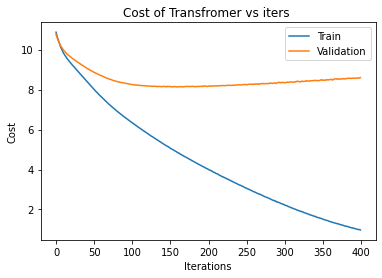

In [ ]:
# plot the cost
plt.plot(train_losses)
plt.plot(validation_losses)
plt.title("Cost of Transfromer vs iters ")
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.legend(labels = ["Train","Validation"])
plt.show()

## Training 

In [ ]:
torch.manual_seed(2045)

pad_idx = 0

# Parameters
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

# Training and validation Data Generators
training_set = AFEC_Dataset(en_train_dic,fa_train_dic,partition['train'],en_vocab_dic, fa_vocab_dic)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  AFEC_Dataset(en_train_dic,fa_train_dic,partition['validation'],en_vocab_dic, fa_vocab_dic)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Hyperparameters
embed_dim = 256
num_heads = 8
dim_key = 64
dim_value = 64
dim_inner = 1024
num_layers = 3
src_vocab_size = len(en_vocab_dic.get_str_2_idx())
trg_vocab_size = len(fa_vocab_dic.get_str_2_idx())
learning_rate = 1e-4
num_iterations = 5000

kwargs = {'p_dropout': 0.1,
          'kdim': dim_key,
          'vdim':dim_value,
          }
# Model
# model = Transformer(num_layers, embed_dim, dim_inner, num_heads, src_vocab_size,trg_vocab_size, device,**kwargs).to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)
optimizer = optim.Adam(model.parameters(), lr = learning_rate, betas=(0.9, 0.98), eps=1e-9)

# train_losses = []
# validation_losses = []

torch.autograd.set_detect_anomaly(True)

train_dataiter = iter(training_generator)

trainloss, valloss, running_trainloss, running_valloss = 0.0, 0.0, 0.0, 0.0

# Loop over epochs
for itr in tqdm(range(num_iterations)):

    # Training        
    batch_train_src, batch_train_trg = train_dataiter.next()

    # Transfer to GPU
    batch_train_src, batch_train_trg = batch_train_src.to(device), batch_train_trg.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = model(batch_train_src, batch_train_trg[: , :-1])
    
    loss = criterion(torch.transpose(batch_train_outputs,1,2), batch_train_trg[: , 1:])

    loss.backward()

    # Clip to avoid exploding gradient issues, makes sure grads are within a healthy range
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1,error_if_nonfinite= False)

    optimizer.step()

    # print statistics
    trainloss += loss.item()
    
    # Validation
    if itr % 500 == 499:
        with torch.set_grad_enabled(False):
            val_cnt = 1
            for batch_src, batch_trg in tqdm(validation_generator):
                # Transfer to GPU
                batch_src, batch_trg = batch_src.to(device), batch_trg.to(device)
                
                # Model computations
                # forward + backward + optimize
                batch_outputs = model(batch_src, batch_trg[: , :-1])
                
                val_loss = criterion(torch.transpose(batch_outputs,1,2), batch_trg[: , 1:])

                valloss += val_loss.item()
                val_cnt += 1

        print("Cost of Train data after %i iterations : %f" %(itr + 1, trainloss / 500))
        print("Cost of Validation data after %i iterations: %f" %(itr + 1, valloss / val_cnt))
        running_valloss = 0

        train_losses.append(trainloss/500)
        trainloss = 0
        validation_losses.append(valloss/val_cnt)
        valloss = 0 


Cost of Train data after 500 iterations : 4.077437
Cost of Validation data after 500 iterations: 4.177563



Cost of Train data after 1000 iterations : 4.076545
Cost of Validation data after 1000 iterations: 4.164702



Cost of Train data after 1500 iterations : 4.067843
Cost of Validation data after 1500 iterations: 4.154782



Cost of Train data after 2000 iterations : 4.059635
Cost of Validation data after 2000 iterations: 4.142466



Cost of Train data after 2500 iterations : 4.053846
Cost of Validation data after 2500 iterations: 4.135002



Cost of Train data after 3000 iterations : 4.037088
Cost of Validation data after 3000 iterations: 4.124817



Cost of Train data after 3500 iterations : 4.040361
Cost of Validation data after 3500 iterations: 4.117778



Cost of Train data after 4000 iterations : 4.026344
Cost of Validation data after 4000 iterations: 4.109282



Cost of Train data after 4500 iterations : 4.020610
Cost of Validation data after 4500 iterations: 4.098103


StopIteration: ignored

In [ ]:
train_dataiter = iter(training_generator)
trainloss, valloss, running_trainloss, running_valloss = 0.0, 0.0, 0.0, 0.0

num_iterations = 5000

# Loop over epochs
for itr in tqdm(range(num_iterations)):

    # Training        
    batch_train_src, batch_train_trg = train_dataiter.next()

    # Transfer to GPU
    batch_train_src, batch_train_trg = batch_train_src.to(device), batch_train_trg.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = model(batch_train_src, batch_train_trg[: , :-1])
    
    loss = criterion(torch.transpose(batch_train_outputs,1,2), batch_train_trg[: , 1:])

    loss.backward()

    # Clip to avoid exploding gradient issues, makes sure grads are within a healthy range
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=2,error_if_nonfinite= False)

    optimizer.step()

    # print statistics
    trainloss += loss.item()
    
    # Validation
    if itr % 500 == 499:
        with torch.set_grad_enabled(False):
            val_cnt = 1
            for batch_src, batch_trg in tqdm(validation_generator):
                # Transfer to GPU
                batch_src, batch_trg = batch_src.to(device), batch_trg.to(device)
                
                # Model computations
                # forward + backward + optimize
                batch_outputs = model(batch_src, batch_trg[: , :-1])
                
                val_loss = criterion(torch.transpose(batch_outputs,1,2), batch_trg[: , 1:])

                valloss += val_loss.item()
                val_cnt += 1

        print("Cost of Train data after %i iterations : %f" %(itr + 1, trainloss / 500))
        print("Cost of Validation data after %i iterations: %f" %(itr + 1, valloss / val_cnt))
        running_valloss = 0

        train_losses.append(trainloss/500)
        trainloss = 0
        validation_losses.append(valloss/val_cnt)
        valloss = 0 


Cost of Train data after 500 iterations : 4.214147
Cost of Validation data after 500 iterations: 4.273641



Cost of Train data after 1000 iterations : 4.207669
Cost of Validation data after 1000 iterations: 4.259844



Cost of Train data after 1500 iterations : 4.193605
Cost of Validation data after 1500 iterations: 4.246597



Cost of Train data after 2000 iterations : 4.182596
Cost of Validation data after 2000 iterations: 4.232274



Cost of Train data after 2500 iterations : 4.181644
Cost of Validation data after 2500 iterations: 4.219688



Cost of Train data after 3000 iterations : 4.161390
Cost of Validation data after 3000 iterations: 4.214949



Cost of Train data after 3500 iterations : 4.161115
Cost of Validation data after 3500 iterations: 4.196480



Cost of Train data after 4000 iterations : 4.144227
Cost of Validation data after 4000 iterations: 4.187565



Cost of Train data after 4500 iterations : 4.141772
Cost of Validation data after 4500 iterations: 4.180213


StopIteration: ignored

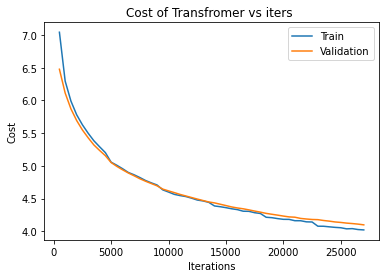

In [ ]:
# plot the cost
plt.plot(range(500,27500,500),train_losses)
plt.plot(range(500,27500,500),validation_losses)
plt.title("Cost of Transfromer vs iters ")
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.legend(labels = ["Train","Validation"])
plt.show()

Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/Transformer1.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
print(train_losses)

[7.043605698585511, 6.296885191917419, 5.99202653503418, 5.781997014045715, 5.628804269790649, 5.499716843605041, 5.384029871940613, 5.291666975975037, 5.203094429016113, 5.0565361375808715, 5.009000703811646, 4.9567625484466555, 4.899050359725952, 4.863669639587402, 4.82200162601471, 4.776107933998108, 4.740412371635437, 4.707698857307434, 4.632751619338989, 4.59986457824707, 4.564599791526795, 4.545856578826904, 4.531093785285949, 4.506484023094178, 4.477768167495728, 4.463965636253357, 4.442565082550049, 4.387112852096558, 4.375498162269592, 4.3609973926544185, 4.3438606424331665, 4.330902749061584, 4.306575284004212, 4.304798285484314, 4.283659282684326, 4.271893107891083, 4.2141468358039855, 4.207668862819672, 4.1936048374176025, 4.182595546722412, 4.1816437344551085, 4.161390475273132, 4.161115400791168, 4.144227269649505, 4.141771843910218, 4.077436944961548, 4.076544713973999, 4.0678434686660765, 4.059634812355042, 4.05384567117691, 4.037088141918183, 4.0403606591224674, 4.0263

In [ ]:
print(validation_losses)

[6.477477967739105, 6.114445004890214, 5.872668937960667, 5.693810649772189, 5.549676311549856, 5.430023546539136, 5.320086118000657, 5.235531264276647, 5.155722340541099, 5.051319510189455, 4.991950946067696, 4.939749171484762, 4.891047031132143, 4.848623677865783, 4.80355553662599, 4.764846461032754, 4.729845322779755, 4.694820641581692, 4.644868017132603, 4.617324741918649, 4.59135195390502, 4.563618867254969, 4.539941929169555, 4.516147624200849, 4.492726012841979, 4.470247595167872, 4.447953905632247, 4.434103411525043, 4.413478537281947, 4.392982181328446, 4.3716673228278085, 4.35614977398915, 4.343683045301864, 4.326986000609042, 4.3090091405519795, 4.292229873030933, 4.273640993370939, 4.259844438798392, 4.24659691283952, 4.232274355283424, 4.219687797685168, 4.214949277799521, 4.196480119406288, 4.187565350710456, 4.180212653839766, 4.177562744759801, 4.1647023945602015, 4.154781518142615, 4.142465530046776, 4.135001771485627, 4.124816796672878, 4.117777992540331, 4.1092820616

## Test 

In [ ]:
torch.manual_seed(2045)

pad_idx = 0

# Parameters
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

# Training and validation Data Generators
test_set0 = AFEC_Dataset(en_test_dic,fa_test_dic0,partition['test'],en_vocab_dic, fa_vocab_dic)
test_generator0 = torch.utils.data.DataLoader(test_set0, **params)
test_set1 = AFEC_Dataset(en_test_dic,fa_test_dic0,partition['test'],en_vocab_dic, fa_vocab_dic)
test_generator1 = torch.utils.data.DataLoader(test_set1, **params)
test_set2 = AFEC_Dataset(en_test_dic,fa_test_dic0,partition['test'],en_vocab_dic, fa_vocab_dic)
test_generator2 = torch.utils.data.DataLoader(test_set2, **params)
test_set3 = AFEC_Dataset(en_test_dic,fa_test_dic0,partition['test'],en_vocab_dic, fa_vocab_dic)
test_generator3 = torch.utils.data.DataLoader(test_set3, **params)


# Hyperparameters
embed_dim = 256
num_heads = 8
dim_key = 64
dim_value = 64
dim_inner = 1024
num_layers = 3
src_vocab_size = len(en_vocab_dic.get_str_2_idx())
trg_vocab_size = len(fa_vocab_dic.get_str_2_idx())
learning_rate = 1e-4

kwargs = {'p_dropout': 0.1,
          'kdim': dim_key,
          'vdim':dim_value,
          }
# Model
# PATH = '/content/drive/My Drive/Transformer1.pth'
# model = Transformer(num_layers, embed_dim, dim_inner, num_heads, src_vocab_size,trg_vocab_size, device,**kwargs).to(device)
# model.load_state_dict(torch.load(PATH))

test_dataiter0 = iter(test_generator0)
test_dataiter1 = iter(test_generator1)
test_dataiter2 = iter(test_generator2)
test_dataiter3 = iter(test_generator3)

list_of_references = []
hypothesises = []
bleu_scores = []
nist_scores = []

# Loop over batches
for num_batch in tqdm(range(len(test_generator0))):
    # Test 
    with torch.set_grad_enabled(False):
        # Transfer to GPU
        batch_src0, batch_trg0 = test_dataiter0.next() 
        batch_src0, batch_trg0 = batch_src0.to(device), batch_trg0.to(device)
        batch_src1, batch_trg1 = test_dataiter1.next() 
        batch_src1, batch_trg1 = batch_src1.to(device), batch_trg1.to(device)
        batch_src2, batch_trg2 = test_dataiter2.next() 
        batch_src2, batch_trg2 = batch_src2.to(device), batch_trg2.to(device)
        batch_src3, batch_trg3 = test_dataiter3.next() 
        batch_src3, batch_trg3 = batch_src3.to(device), batch_trg3.to(device)

        # Model computations
        # forward + backward + optimize
        batch_outputs1 = model(batch_src0, batch_trg0[: , :-1])
        batch_outputs = model.translate_sentence(batch_src0, batch_trg0.shape[1] + 5, 1, 2)
        batch_outputs = torch.Tensor(batch_outputs)

        references = [fa_vocab_dic.IndexDecoding(batch_trg0[0,:]),fa_vocab_dic.IndexDecoding(batch_trg1[0,:]),
                      fa_vocab_dic.IndexDecoding(batch_trg2[0,:]),fa_vocab_dic.IndexDecoding(batch_trg3[0,:])]
        list_of_references.append(references)
        
        hypothesises.append(fa_vocab_dic.IndexDecoding(batch_outputs))
        bleu_scores.append(sentence_bleu(references,fa_vocab_dic.IndexDecoding(batch_outputs)))
        nist_scores.append(sentence_nist(references,fa_vocab_dic.IndexDecoding(batch_outputs)))
        
        # print(batch_src0.shape, batch_trg0.shape, len(batch_outputs))
        # print(en_vocab_dic.IndexDecoding(batch_src0[0,:])[1:-1])
        # print(fa_vocab_dic.IndexDecoding(batch_trg0[0,:])[1:-1])
        # print(fa_vocab_dic.IndexDecoding(batch_outputs)[1:-1])
        # if num_batch == 5:
        #   break

bleu_score = corpus_bleu(list_of_references, hypothesises) 
nist_score = corpus_nist(list_of_references, hypothesises, n = 5)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print(bleu_score,nist_score)

0.06216927618083542 0.0010401418852129015


In [ ]:
print(np.mean(bleu_scores),np.mean(nist_scores))

0.470767768389585 0.07479292648936205


In [ ]:
print(fa_vocab_dic.IndexDecoding(torch.max(batch_outputs1, dim = 2)[1][0,:]))

['بله', 'ما', 'ساعت', 'عصر', 'امروز', 'که', 'ما', 'چیز', 'درباره', 'کنیم', 'ما']


In [ ]:
torch.manual_seed(2045)

pad_idx = 0

# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

# Training and validation Data Generators
test_set = AFEC_Dataset(en_test_dic,fa_test_dic0,partition['test'],en_vocab_dic, fa_vocab_dic)
test_generator = torch.utils.data.DataLoader(test_set, **params)

# Hyperparameters
embed_dim = 256
num_heads = 8
dim_key = 64
dim_value = 64
dim_inner = 1024
num_layers = 3
src_vocab_size = len(en_vocab_dic.get_str_2_idx())
trg_vocab_size = len(fa_vocab_dic.get_str_2_idx())
learning_rate = 1e-4
num_iterations = 10

kwargs = {'p_dropout': 0.1,
          'kdim': dim_key,
          'vdim':dim_value,
          }
# Model
# PATH = '/content/drive/My Drive/Transformer1.pth'
# model = Transformer(num_layers, embed_dim, dim_inner, num_heads, src_vocab_size,trg_vocab_size, device,**kwargs).to(device)
# model.load_state_dict(torch.load(PATH))

test_dataiter = iter(test_generator)

# Loop over epochs
for itr in tqdm(range(num_iterations)):
    
    # Test
    batch_src, batch_trg = test_dataiter.next() 
    
    with torch.set_grad_enabled(False):


        # Model computations
        # forward + backward + optimize
        
        batch_outputs = model.translate_sentence(batch_src, batch_trg.shape[1] + 5, 1, 2)
        batch_outputs = torch.Tensor(batch_outputs)

        print("Sentence {}:".format(itr + 1))
        print(" ".join(en_vocab_dic.IndexDecoding(batch_src[0,:])).replace("<sos>", "").replace("<eos>", "."))
        print(" ".join(fa_vocab_dic.IndexDecoding(batch_trg[0,:])).replace("<sos>", "").replace("<eos>", "").replace("<unk>","ن.ش"))
        print(" ".join(fa_vocab_dic.IndexDecoding(batch_outputs)).replace("<sos>", "").replace("<eos>", "").replace("<unk>","ن.ش"))
        print("-"*50)

Sentence 1:
 once again shall we stay at the hotel <unk> .
 یکبار دیگر آیا قرار است در هتل ن.ش بمانیم 
 وقتی که وقتی در هتل هتل هتل ن.ش 
--------------------------------------------------
Sentence 2:
 fine let us go for a little walk in hamburg .
 خوب است اجازه دهید برای یک کوتاه در هامبورگ برویم 
 اجازه دهید برای اینکه اجازه بدهید به ن.ش ن.ش برای ن.ش به ن.ش 
--------------------------------------------------
Sentence 3:
 yes i have already booked the hotel .
 بله من در حال حاضر هتل را رزرو 
 بله هتل ن.ش را رزرو 
--------------------------------------------------
Sentence 4:
 in the evening we should watch the newest movie with arnold schwarzenegger .
 عصر باید جدیدترین فیلم آرنولد ن.ش را تماشا کنیم 
 ما باید با ن.ش در عصر عصر ن.ش در عصر با ن.ش 
--------------------------------------------------
Sentence 5:
 where should we meet .
 کجا باید ملاقات کنیم 
 کجا باید ببینیم کجا باید ببینیم و باید همدیگر را ببینیم
--------------------------------------------------
Sentence 6:
 hello i would

# Part 2:

## Preprocessing

### Load the dataset to colab directory 

For the sake of speed, copy the dataset files to the root directory of notebook and unziped them. 

In [ ]:
!cp /content/drive/My\ Drive/AFEC-merged-all.zip /content/AFEC-merged-all.zip

In [ ]:
!cp /content/drive/My\ Drive/Test.zip /content/Test.zip

In [ ]:
!unzip /content/AFEC-merged-all.zip

Archive:  /content/AFEC-merged-all.zip
  inflating: AFEC-merged.en          
  inflating: AFEC-merged.fa          


In [ ]:
os.rename('/content/AFEC-merged.en',"/content/AFEC-merged_en.txt")
os.rename('/content/AFEC-merged.fa',"/content/AFEC-merged_fa.txt")

In [ ]:
!unzip /content/Test.zip

Archive:  /content/Test.zip
   creating: Test/
  inflating: Test/test.en            
  inflating: Test/test.fa0           
  inflating: Test/test.fa1           
  inflating: Test/test.fa2           
  inflating: Test/test.fa3           


In [ ]:
os.rename('/content/Test/test.en',"/content/test_en.txt")
os.rename('/content/Test/test.fa0',"/content/test_fa0.txt")
os.rename('/content/Test/test.fa1',"/content/test_fa1.txt")
os.rename('/content/Test/test.fa2',"/content/test_fa2.txt")
os.rename('/content/Test/test.fa3',"/content/test_fa3.txt")

### Vocabulary2 

In [ ]:
class Vocabulary_and_Dictionary2():

    def __init__(self, freq_threshold = 2):
        self.freq_threshold = freq_threshold
        
        self.frequencies = {}
        self.idx_2_str = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.str_2_idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}

    def __len__(self):
        return len(self.idx_2_str)

    def preprocess(self,text):
        # prepare translation table for removing punctuation
        table = str.maketrans('', '', string.punctuation)

        # tokenize on white space
        text = text.split()
        # convert to lower case
        text = [word.lower() for word in text]
        # remove punctuation from each token
        text = [word.translate(table) for word in text]

        # remove tokens with numbers in them
        text = [word for word in text if word.isalpha()]
        
        text1 = " ".join(text)

        return text, self.tokenizer.tokenize(text1)[0]

    def build_vocabulary_and_dictionary(self, text_file_root, num_symbols):

        self.dic = {}
        
        idx = 4
        lines = [line.strip() for line in open(text_file_root)]

        args = {"mode": "aggressive",
                "joiner_annotate": True,
                "preserve_placeholders": True,
                "case_markup": True,
                "soft_case_regions": True,
                "preserve_segmented_tokens": True,}

        tokenizer = pyonmttok.Tokenizer(**args)
        learner = pyonmttok.BPELearner(tokenizer=tokenizer, symbols= num_symbols)
        # learner = pyonmttok.SentencePieceLearner(vocab_size = num_symbols, character_coverage = 0.98)

        for i in range(len(lines)):
            learner.ingest(lines[i])

        # learn and store bpe model
        self.tokenizer = learner.learn("model.32k")#("subword.bpe")
        
        for i in range(len(lines)):

            sentence, words =  self.preprocess(lines[i])
            for word in words:
                if word not in self.frequencies:
                    self.frequencies[word] = 1

                else:
                    self.frequencies[word] += 1

                if self.frequencies[word] == self.freq_threshold:
                    self.str_2_idx[word] = idx
                    self.idx_2_str[idx] = word
                    idx += 1

            self.dic[i] = [" ".join(sentence)] 

    def IndexEncoding(self, text):
        _, tokenized_text = self.preprocess(text)
        index_encoded_text = [self.str_2_idx[token] if token in self.str_2_idx else self.str_2_idx["<unk>"]
                                for token in tokenized_text]
        
        return index_encoded_text

    def IndexDecoding(self, sen_tensor):
        tokenized_vec = list(sen_tensor.cpu().numpy())
        decoded_vec = [self.idx_2_str[token] for token in tokenized_vec]
        return decoded_vec

    def get_str_2_idx(self):
        return self.str_2_idx

    def get_dic(self):
        return self.dic

In [ ]:
en_vocab_dic_ = Vocabulary_and_Dictionary2(freq_threshold = 10)

train_text_root = "/content/AFEC-merged_en.txt"
en_vocab_dic_.build_vocabulary_and_dictionary(train_text_root, 32000)

en_train_dic_ = en_vocab_dic_.get_dic() 

print(len(en_vocab_dic_.get_str_2_idx()))

28778


In [ ]:
en_train_dic_[0],len(en_train_dic_)

(['north waziristan operation kills more militants'], 684417)

In [ ]:
fa_vocab_dic_ = Vocabulary_and_Dictionary2(freq_threshold = 10)

train_text_root1 = "/content/AFEC-merged_fa.txt"
fa_vocab_dic_.build_vocabulary_and_dictionary(train_text_root1,32000)

fa_train_dic_ = fa_vocab_dic_.get_dic() 

print(len(fa_vocab_dic_.get_str_2_idx()))

29012


In [ ]:
fa_train_dic_[0],len(fa_train_dic_)

(['مرگ ستیزه جوی دیگر در عملیات وزیرستان شمالی'], 684417)

In [ ]:
en_vocab_dic_2 = Vocabulary_and_Dictionary2(freq_threshold = 2)

test_text_root = "/content/test_en.txt"
en_vocab_dic_2.build_vocabulary_and_dictionary(test_text_root,357)

en_test_dic_ = en_vocab_dic_2.get_dic() 

print(len(en_vocab_dic_2.get_str_2_idx()))

285


In [ ]:
fa_vocab_dic_2 = Vocabulary_and_Dictionary2(freq_threshold = 2)

test_text_root0 = "/content/test_fa0.txt"
fa_vocab_dic_2.build_vocabulary_and_dictionary(test_text_root0,337)

fa_test_dic_0 = fa_vocab_dic_2.get_dic() 

test_text_root1 = "/content/test_fa1.txt"
fa_vocab_dic_2.build_vocabulary_and_dictionary(test_text_root1,337)

fa_test_dic_1 = fa_vocab_dic_2.get_dic() 

test_text_root2 = "/content/test_fa2.txt"
fa_vocab_dic_2.build_vocabulary_and_dictionary(test_text_root2,337)

fa_test_dic_2 = fa_vocab_dic_2.get_dic() 

test_text_root3 = "/content/test_fa3.txt"
fa_vocab_dic_2.build_vocabulary_and_dictionary(test_text_root3,337)

fa_test_dic_3 = fa_vocab_dic_2.get_dic() 

print(len(fa_vocab_dic_2.get_str_2_idx()))

460


In [ ]:
en_test_dic_

{0: ['hello do we drive together to hanover on the twentyeighth of march'],
 1: ['it is more comfortable by train'],
 2: ['do you go by car and i go by train'],
 3: ['i would like to go by train and what would you like'],
 4: ['if we take the ice train at six past seven we will arrive at twentyfive past eight'],
 5: ['which cafe'],
 6: ['the cafe at platform fourteen'],
 7: ['in any case a cheap hotel'],
 8: ['what did you say please'],
 9: ['and how much is a single room'],
 10: ['we can take a taxi from the station to the hotel'],
 11: ['at which hotel do you want to reserve a room now and how much is a single room'],
 12: ['okay should we drive back on friday evening'],
 13: ['i think we rather drive back at thirtythree past nine then we will arrive at hamburg at fiftytwo past ten'],
 14: ['fine and dont forget your swimming stuff maybe we can go swimming together'],
 15: ['yes when and where do we want to meet'],
 16: ['i prefer the plane'],
 17: ['a good idea then we will meet at 

In [ ]:
fa_vocab_dic_2.get_str_2_idx()

{'<eos>': 2,
 '<pad>': 0,
 '<sos>': 1,
 '<unk>': 3,
 'آلمان': 174,
 'آلمانی': 33,
 'آن': 143,
 'آنجا': 169,
 'آن￭': 276,
 'آیا': 7,
 'آ￭': 6,
 'ئ￭': 226,
 'ا': 107,
 'اتاق': 26,
 'اتا￭': 288,
 'ات￭': 4,
 'اجازه': 269,
 'اج￭': 14,
 'اح￭': 37,
 'ار': 13,
 'ارز￭': 170,
 'اری': 39,
 'ار￭': 38,
 'از': 137,
 'از￭': 82,
 'است': 6,
 'اس￭': 35,
 'اقامت': 29,
 'الان': 11,
 'الی': 64,
 'ام': 239,
 'اما': 65,
 'ام￭': 24,
 'ان': 171,
 'انت￭': 216,
 'انجا': 30,
 'انجام': 202,
 'انه': 231,
 'انو￭': 41,
 'ان￭': 177,
 'اه': 43,
 'اهم': 46,
 'اوم': 58,
 'اکسپو': 164,
 'اکسپ￭': 16,
 'اک￭': 17,
 'ای': 257,
 'ایا': 4,
 'اید': 35,
 'ایده': 9,
 'ایستگاه': 106,
 'ایست￭': 26,
 'ایم': 84,
 'این': 128,
 'اینجا': 148,
 'این￭': 95,
 'ای￭': 38,
 'ا￭': 39,
 'ب': 217,
 'با': 4,
 'بار': 240,
 'باز￭': 139,
 'باشد': 36,
 'باشم': 249,
 'باشه': 189,
 'باشیم': 28,
 'باش￭': 241,
 'باهم': 8,
 'باید': 45,
 'با￭': 205,
 'ببینیم': 55,
 'بده': 60,
 'بدهید': 78,
 'بدهیم': 38,
 'بده￭': 19,
 'برای': 72,
 'برنامه': 76,
 'بروم': 188,

### AFEC Dataset

In [ ]:
class AFEC_Dataset(torch.utils.data.Dataset):
    """
    Characterize AFEC Dataset for PyTorch. To be compatible with 
    DataLoader and other PyTorch syntaxes.
    """
    def __init__(self, src_dic, trg_dic, indices, src_vocab, trg_vocab):
        
        self.src_dic = src_dic
        self.trg_dic = trg_dic

        # Get img names, caption columns
        self.src_sentences = [self.src_dic[i] for i in indices]
        self.trg_sentences = [self.trg_dic[i] for i in indices]

        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab 
            
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.src_sentences)

    def __getitem__(self, index):
        """ 
        Generates one sample of data with label
        
        Arguments
        ------------
        index : integer, in range of len(self.list_IDs)
                index of sample in list of IDs,
        
        Returns
        ------------
        X : torch tensor,
            input data

        Y : torch tensor,
            correspond label of input data
        """
        # Select sample
        src_sentence = [ self.src_vocab.str_2_idx["<sos>"] ]
        src_sentence += self.src_vocab.IndexEncoding(self.src_sentences[index][0])
        src_sentence.append(self.src_vocab.str_2_idx["<eos>"])

        trg_sentence = [ self.trg_vocab.str_2_idx["<sos>"] ]
        trg_sentence += self.trg_vocab.IndexEncoding(self.trg_sentences[index][0])
        trg_sentence.append(self.trg_vocab.str_2_idx["<eos>"])
       
        tensor_src_sentence = torch.tensor(src_sentence)
        tensor_trg_sentence = torch.tensor(trg_sentence)

        return tensor_src_sentence , tensor_trg_sentence

### Split Dataset and Activate CUDA

In [ ]:
#train/val/test split 
random.seed(2045)

indices = list(range(len(en_train_dic_)))
num_samples = len(en_train_dic_)
random.shuffle(indices)

train_indices = indices[0 : int(0.9 * num_samples)]
validation_indices = indices[int(0.9 * num_samples) : ]
test_indices = list(range(len(en_test_dic_)))

partition2 = {'train' : train_indices , 'validation' : validation_indices,
             'test' : test_indices }

In [ ]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
len(partition2['test'])

250

### Padding

In [ ]:
class BatchPadCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):

        src_sentences = [item[0] for item in batch]
        src_sentences = pad_sequence(src_sentences, batch_first= True, padding_value=self.pad_idx)

        trg_sentences = [item[1] for item in batch]
        trg_sentences = pad_sequence(trg_sentences, batch_first= True, padding_value=self.pad_idx) 
        
        return src_sentences, trg_sentences 

## Transformer Network 

In [ ]:
class PositionalEncoding(nn.Module):
    
    def __init__(self,embed_dim, p_dropout, maximum_position_encoding):
        super(PositionalEncoding, self).__init__()
        
        self.max_pos = maximum_position_encoding
        self.dropout = nn.Dropout(p_dropout)
        pos_enc = torch.zeros(self.max_pos, embed_dim)
        positions = torch.arange(0, self.max_pos, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pos_enc[:, 0::2] = torch.sin(positions * div_term)
        pos_enc[:, 1::2] = torch.cos(positions * div_term)
        pos_enc = pos_enc.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pos_enc', pos_enc)

    def forward(self, x):
        x = x + self.pos_enc[:x.size(0), :]
        x = self.dropout(x)
        
        return x


In [ ]:
class _ScaledDotProductAttention(nn.Module):
    
    def __init__(self, embed_dim, device, p_dropout=0., kdim=None, vdim=None):
        super(_ScaledDotProductAttention, self).__init__()
        self.device = device
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim

        self.dropout = nn.Dropout(p_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, query: Tensor, key: Tensor, value: Tensor, mask: Optional[Tensor] = None) -> Tuple[Tensor, Tensor]:
          
        """
        Calculate the attention weights.
        q, k, v must have matching leading dimensions.
        k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
        The mask has different shapes depending on its type(padding or look ahead)
        but it must be broadcastable for addition.

        Args:
            query : query shape == (..., seq_len_q, depth)
            key : key shape == (..., seq_len_k, depth)
            value: value shape == (..., seq_len_v, depth_v)
            mask: Float tensor with shape broadcastable
                to (..., seq_len_q, seq_len_k). Defaults to None.

        Returns:
            output, attention_weights
        """
        qk = torch.matmul(query, torch.transpose(key,2,3))  # (..., seq_len_q, seq_len_k)
        
        # scale matmul_qk
        scaled_attention_logits = qk / math.sqrt(self.kdim)

        # add the mask to the scaled tensor.
        if mask is not None:
            scaled_attention_logits = scaled_attention_logits.masked_fill(mask == 1, -1e10)
        
        # softmax is normalized on the last axis (seq_len_k) so that the scores
        # add up to 1.
        attention_weights = self.softmax(scaled_attention_logits)  # (..., seq_len_q, seq_len_k)
        
        attention_weights = self.dropout(attention_weights)
        
        output = torch.matmul(attention_weights, value)  # (..., seq_len_q, depth_v)

        return output

In [ ]:
class _MultiHeadAttention(nn.Module):
    
    def __init__(self, embed_dim, num_heads, device, p_dropout=0.,
                 kdim=None, vdim=None, epsilon = 1e-5):
        super(_MultiHeadAttention, self).__init__()
        
        self.device = device 
        self.embed_dim = embed_dim                               
        self.num_heads = num_heads
        self.kdim = kdim * num_heads if kdim is not None else embed_dim
        self.vdim = vdim * num_heads if vdim is not None else embed_dim
        self.d_model = self.vdim 
        self.head_dim = self.d_model // num_heads
        assert self.head_dim * num_heads == self.d_model, "embed_dim must be divisible by num_heads"

        self.Wq = nn.Linear(embed_dim, self.kdim,device = device)
        self.Wk = nn.Linear(embed_dim, self.kdim,device = device)
        self.Wv = nn.Linear(embed_dim, self.vdim,device = device)

        self.self_attention = _ScaledDotProductAttention(self.head_dim, device,p_dropout, kdim, vdim)
        self.layernorm = nn.LayerNorm((embed_dim,), eps = epsilon, device = device)
        self.linear = nn.Linear(self.vdim, embed_dim,device = device)
        self.dropout = nn.Dropout(p_dropout)

    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = x.view((batch_size, -1, self.num_heads, self.head_dim))
        return torch.transpose(x,1,2)

    def forward(self, query: Tensor, key: Tensor, value: Tensor, mask: Optional[Tensor] = None) -> Tuple[Tensor, Tensor]:
        
        batch_size = query.shape[0]

        q = self.Wq(query)  # (batch_size, seq_len, d_model)
        k = self.Wk(key)    # (batch_size, seq_len, d_model)
        v = self.Wv(value)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention = self.self_attention(q, k, v, mask)

        scaled_attention = torch.transpose(scaled_attention, 1,2)  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = scaled_attention.reshape((batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.linear(concat_attention)  # (batch_size, seq_len_q, d_model)

        output = self.dropout(output)
        output = self.layernorm(value + output)
        return output

In [ ]:
class _PointwiseFeedicorward(nn.Module):
    
    def __init__(self, embed_dim, inner_dim,device, p_dropout=0.,epsilon = 1e-5):
        super(_PointwiseFeedicorward, self).__init__()

        self.linear1 = nn.Linear(embed_dim, inner_dim,device = device)
        self.linear2 = nn.Linear(inner_dim, embed_dim,device = device)
        self.layernorm = nn.LayerNorm((embed_dim,), eps = epsilon,device = device)
        self.dropout = nn.Dropout(p_dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.linear1(x)
        x1 = self.relu(x1)
        x1 = self.dropout(x1)
        x1 = self.linear2(x1)
        x1 = self.dropout(x1) 
        x1 = self.layernorm(x + x1)

        return x1

In [ ]:
class _EncoderLayer(nn.Module):
    
    def __init__(self, embed_dim, inner_dim, num_heads, device, p_dropout = 0.,
                 kdim = None, vdim = None,epsilon = 1e-5):
        super(_EncoderLayer, self).__init__()

        self.device = device
        self.mha = _MultiHeadAttention(embed_dim, num_heads, device, p_dropout, kdim, vdim)
        self.ff =  _PointwiseFeedicorward(embed_dim, inner_dim, device, p_dropout,epsilon = 1e-5)

    def forward(self, x, mask = None):
        
        x = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        x = self.ff(x)         # (batch_size, input_seq_len, d_model)

        return x

In [ ]:
class _TransformerEncoder(nn.Module):
    
    def __init__(self,num_layers, embed_dim,inner_dim, num_heads, device,
                 p_dropout = 0., kdim = None, vdim = None, epsilon = 1e-5):
        
        super(_TransformerEncoder, self).__init__()

        self.num_layers = num_layers 
        self.device = device
        
        kwrgs = {'p_droput': p_dropout, 'kdim': kdim, 'vdim': vdim, 'epsilon': epsilon}
        # self.enc_layers = [_EncoderLayer(embed_dim, inner_dim, num_heads,device,**kwargs) for _ in range(num_layers)]
        
        self.enc_layers = nn.ModuleList([_EncoderLayer(embed_dim, inner_dim, num_heads,device,**kwargs) for _ in range(num_layers)])
    def forward(self, x, mask):
        
        # for i in range(self.num_layers):
        #     x = self.enc_layers[i](x, mask)
        for layer in self.enc_layers:
            x = layer(x,mask)
        return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class Transformer(nn.Module):

    def __init__(self, num_layers, embed_dim, ff_dim, num_heads, src_vocab_size,
                 trg_vocab_size, device, p_dropout = 0., kdim = None,
                 vdim = None, maximum_position_encoding = 5000, epsilon = 1e-5):
        
        super(Transformer, self).__init__()

        self.device = device

        self.src_embedding = nn.Embedding(src_vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, p_dropout, maximum_position_encoding)
        self.scale = embed_dim
        kwrgs = {'p_droput': p_dropout, 'kdim': kdim, 'vdim': vdim, 'epsilon': epsilon}
        self.transformer_encoder = _TransformerEncoder(num_layers, embed_dim, ff_dim,
                                                       num_heads,device = device, **kwargs)
        

        self.trg_embedding = nn.Embedding(trg_vocab_size, embed_dim)
        self.pos_decoder = PositionalEncoding(embed_dim, p_dropout, maximum_position_encoding)
        self.decoder_layer = TransformerDecoderLayer(embed_dim, num_heads, dim_feedforward = ff_dim,
                                                     dropout = p_dropout, layer_norm_eps = epsilon, 
                                                     batch_first = True, device = device)
        self.transformer_decoder = TransformerDecoder(self.decoder_layer, num_layers)


        self.trg_classifier = nn.Linear(embed_dim, trg_vocab_size)

    def make_padding_mask(self, seq, pad_idx):
        seq_mask = seq == pad_idx
        return seq_mask.to(self.device)
    
    def make_src_padding_mask(self, seq, pad_idx):
        seq_mask = seq == pad_idx
        return seq_mask.view(seq.shape[0],1,1,-1).to(self.device)

    def generate_square_subsequent_mask(self, sz: int) -> Tensor:
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask.to(self.device)

    def forward(self, src, trg):
        
        src_padding_mask = self.make_src_padding_mask(src, 0)
        mem_padding_mask = self.make_padding_mask(src, 0)
        src = self.src_embedding(src).to(self.device) * math.sqrt(self.scale)
        src = self.pos_encoder(src).to(self.device)

        enc_output = self.transformer_encoder(src, src_padding_mask) # (batch_size, src_seq_len, d_model)


        trg_padding_mask = self.make_padding_mask(trg, 0)
        trg_mask = self.generate_square_subsequent_mask(trg.shape[1])
        kwargs = {'tgt_mask': trg_mask, 'tgt_key_padding_mask': trg_padding_mask, 'memory_key_padding_mask': mem_padding_mask}
        trg = self.trg_embedding(trg).to(self.device) * math.sqrt(self.scale)
        trg = self.pos_decoder(trg).to(self.device)

        dec_output = self.transformer_decoder(trg, enc_output,**kwargs) # (batch_size, trg_seq_len, d_model)


        final_output = self.trg_classifier(dec_output) # (batch_size, trg_seq_len, trg_vocab_size)

        return final_output 

    # function to generate output sequence using greedy algorithm
    def greedy_decode(self, src, max_len, sos_idx, eos_idx):
        src = src.to(self.device)

        # memory = self.encode(src).to(device)
        y_pred = torch.ones(1, 1).fill_(sos_idx).type(torch.long).to(self.device)

        for i in range(max_len-1):
            
            trg_mask = (self.generate_square_subsequent_mask(y_pred.size(1)).type(torch.bool)).to(self.device)
            out = self.decode(src, y_pred, trg_mask)
            # out = out.transpose(0, 1)
            prob = self.trg_classifier(out[0, :, -1])
            _, next_word = torch.max(prob, dim=0)
            next_word = next_word.item()
            y_pred = torch.cat([y_pred, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
            if next_word == eos_idx:
                break
        return y_pred

    def encode(self, src, mask):
        src = self.src_embedding(src).to(self.device) * math.sqrt(self.scale)
        src = self.pos_encoder(src)

        enc_output = self.transformer_encoder(src, mask) # (batch_size, src_seq_len, d_model)
        return enc_output
    
    def decode(self, trg, src_enc, trg_mask, mem_padding_mask):
        kwargs = {'tgt_mask': trg_mask,'memory_key_padding_mask': mem_padding_mask}
        
        trg = self.trg_embedding(trg).to(self.device) * math.sqrt(self.scale)
        trg = self.pos_decoder(trg)
        # dec_output.shape == (batch_size, trg_seq_len, d_model)
        dec_output = self.transformer_decoder(trg, src_enc, **kwargs)
        final_output = self.trg_classifier(dec_output) # (batch_size, trg_seq_len, trg_vocab_size)

        return final_output

    def translate_sentence(self,src,max_len, sos_idx, eos_idx):
        src = src.to(self.device)
        src_padding_mask = self.make_src_padding_mask(src, 0)
        mem_padding_mask = self.make_padding_mask(src, 0)

        enc_src = self.encode(src, src_padding_mask)

        trg_indexes = [sos_idx]

        for i in range(max_len):

            trg = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
            trg_mask = self.generate_square_subsequent_mask(trg.shape[1])

            output = self.decode(trg, enc_src, trg_mask, mem_padding_mask)
            
            pred_token = output.argmax(2)[:,-1].item()
            
            trg_indexes.append(pred_token)

            if pred_token == eos_idx:
                break
        
        return trg_indexes

## Sanity Check 
(try to overfit on a mini batch)

In [ ]:
torch.manual_seed(2045)

pad_idx = 0

# Parameters
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

# Training and validation Data Generators
training_set2 = AFEC_Dataset(en_train_dic_,fa_train_dic_,partition2['train'],en_vocab_dic_, fa_vocab_dic_)
training_generator2 = torch.utils.data.DataLoader(training_set2, **params)

validation_set2 =  AFEC_Dataset(en_train_dic_,fa_train_dic_,partition2['validation'],en_vocab_dic_, fa_vocab_dic_)
validation_generator2 = torch.utils.data.DataLoader(validation_set2, **params)

# Hyperparameters
embed_dim = 256
num_heads = 8
dim_key = 64
dim_value = 64
dim_inner = 1024
num_layers = 3
src_vocab_size = len(en_vocab_dic_.get_str_2_idx())
trg_vocab_size = len(fa_vocab_dic_.get_str_2_idx())
learning_rate = 1e-4
num_iterations = 400

kwargs = {'p_dropout': 0.1,
          'kdim': dim_key,
          'vdim':dim_value,
          }
# Model
model2 = Transformer(num_layers, embed_dim, dim_inner, num_heads, src_vocab_size,trg_vocab_size, device,**kwargs).to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)
optimizer = optim.Adam(model2.parameters(), lr = learning_rate, betas=(0.9, 0.98), eps=1e-9)

train_losses2 = []
validation_losses2 = []

torch.autograd.set_detect_anomaly(True)

train_dataiter2 = iter(training_generator2)
batch_train_src, batch_train_trg = train_dataiter2.next()
dataiter2 = iter(validation_generator2)
batch_src, batch_trg = dataiter2.next() 

trainloss, valloss, running_trainloss, running_valloss = 0.0, 0.0, 0.0, 0.0

# Loop over epochs
for itr in tqdm(range(num_iterations)):

    # Training        
    # Transfer to GPU
    batch_train_src, batch_train_trg = batch_train_src.to(device), batch_train_trg.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = model2(batch_train_src, batch_train_trg[: , :-1])
    
    loss = criterion(torch.transpose(batch_train_outputs,1,2), batch_train_trg[: , 1:])

    loss.backward()

    # Clip to avoid exploding gradient issues, makes sure grads are within a healthy range
    nn.utils.clip_grad_norm_(model2.parameters(), max_norm=2,error_if_nonfinite= False)

    optimizer.step()

    # print statistics
    trainloss = loss.item()
    running_trainloss += loss.item()

    if itr % 100 == 99:    # print every 100 mini-batches
        print("Cost of Train data after %i iterations : %f" %(itr + 1, running_trainloss / 100))
        running_trainloss = 0
    
    # Validation
    with torch.set_grad_enabled(False):
        # Transfer to GPU
        batch_src, batch_trg = batch_src.to(device), batch_trg.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = model2(batch_src, batch_trg[: , :-1])
        
        val_loss = criterion(torch.transpose(batch_outputs,1,2), batch_trg[: , 1:])

        valloss = val_loss.item()
        running_valloss += val_loss.item()

        if itr % 100 == 99:    # print every 100 mini-batches
            print("Cost of Validation data after %i iterations: %f" %(itr + 1, running_valloss / 100))
            running_valloss = 0

    train_losses2.append(trainloss)
    validation_losses2.append(valloss)


Cost of Train data after 100 iterations : 4.961051
Cost of Validation data after 100 iterations: 5.268263
Cost of Train data after 200 iterations : 1.881628
Cost of Validation data after 200 iterations: 3.707742
Cost of Train data after 300 iterations : 0.837785
Cost of Validation data after 300 iterations: 4.104653
Cost of Train data after 400 iterations : 0.340454
Cost of Validation data after 400 iterations: 4.525049



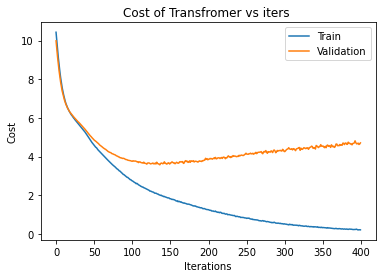

In [ ]:
# plot the cost
plt.plot(train_losses2)
plt.plot(validation_losses2)
plt.title("Cost of Transfromer vs iters ")
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.legend(labels = ["Train","Validation"])
plt.show()

## Training 

In [ ]:
torch.manual_seed(2045)

pad_idx = 0

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

# Training and validation Data Generators
training_set2 = AFEC_Dataset(en_train_dic_,fa_train_dic_,partition2['train'],en_vocab_dic_, fa_vocab_dic_)
training_generator2 = torch.utils.data.DataLoader(training_set2, **params)

validation_set2 =  AFEC_Dataset(en_train_dic_,fa_train_dic_,partition2['validation'],en_vocab_dic_, fa_vocab_dic_)
validation_generator2 = torch.utils.data.DataLoader(validation_set2, **params)

# Hyperparameters
embed_dim = 256
num_heads = 8
dim_key = 64
dim_value = 64
dim_inner = 1024
num_layers = 3
src_vocab_size = len(en_vocab_dic_.get_str_2_idx())
trg_vocab_size = len(fa_vocab_dic_.get_str_2_idx())
learning_rate = 1e-4
num_iterations = 10000

kwargs = {'p_dropout': 0.1,
          'kdim': dim_key,
          'vdim':dim_value,
          }
# Model
# model2 = Transformer(num_layers, embed_dim, dim_inner, num_heads, src_vocab_size,trg_vocab_size, device,**kwargs).to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)
optimizer = optim.Adam(model2.parameters(), lr = learning_rate, betas=(0.9, 0.98), eps=1e-9)

# train_losses2 = []
# validation_losses2 = []

torch.autograd.set_detect_anomaly(True)

train_dataiter2 = iter(training_generator2)

trainloss, valloss, running_trainloss, running_valloss = 0.0, 0.0, 0.0, 0.0

# Loop over epochs
for itr in tqdm(range(num_iterations)):

    # Training        
    batch_train_src, batch_train_trg = train_dataiter2.next()

    # Transfer to GPU
    batch_train_src, batch_train_trg = batch_train_src.to(device), batch_train_trg.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = model2(batch_train_src, batch_train_trg[: , :-1])
    
    loss = criterion(torch.transpose(batch_train_outputs,1,2), batch_train_trg[: , 1:])

    loss.backward()

    # Clip to avoid exploding gradient issues, makes sure grads are within a healthy range
    nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1,error_if_nonfinite= False)

    optimizer.step()

    # print statistics
    trainloss += loss.item()
    
    # Validation
    if itr % 1000 == 999:
        with torch.set_grad_enabled(False):
            val_cnt = 1
            for batch_src, batch_trg in tqdm(validation_generator2):
                # Transfer to GPU
                batch_src, batch_trg = batch_src.to(device), batch_trg.to(device)
                
                # Model computations
                # forward + backward + optimize
                batch_outputs = model2(batch_src, batch_trg[: , :-1])
                
                val_loss = criterion(torch.transpose(batch_outputs,1,2), batch_trg[: , 1:])

                valloss += val_loss.item()
                val_cnt += 1

        print("Cost of Train data after %i iterations : %f" %(itr + 1, trainloss / 1000))
        print("Cost of Validation data after %i iterations: %f" %(itr + 1, valloss / val_cnt))
        running_valloss = 0

        train_losses2.append(trainloss/1000)
        trainloss = 0
        validation_losses2.append(valloss/val_cnt)
        valloss = 0 


Cost of Train data after 1000 iterations : 4.320658
Cost of Validation data after 1000 iterations: 4.402590



Cost of Train data after 2000 iterations : 4.323213
Cost of Validation data after 2000 iterations: 4.393533



Cost of Train data after 3000 iterations : 4.314763
Cost of Validation data after 3000 iterations: 4.381490



Cost of Train data after 4000 iterations : 4.310287
Cost of Validation data after 4000 iterations: 4.368315



Cost of Train data after 5000 iterations : 4.306546
Cost of Validation data after 5000 iterations: 4.359262



Cost of Train data after 6000 iterations : 4.291003
Cost of Validation data after 6000 iterations: 4.353517



Cost of Train data after 7000 iterations : 4.296267
Cost of Validation data after 7000 iterations: 4.345494



Cost of Train data after 8000 iterations : 4.284499
Cost of Validation data after 8000 iterations: 4.334650



Cost of Train data after 9000 iterations : 4.283088
Cost of Validation data after 9000 iterations: 4.327861


StopIteration: ignored

In [ ]:
train_dataiter2 = iter(training_generator2)

trainloss, valloss, running_trainloss, running_valloss = 0.0, 0.0, 0.0, 0.0

# Loop over epochs
for itr in tqdm(range(num_iterations)):

    # Training        
    batch_train_src, batch_train_trg = train_dataiter2.next()

    # Transfer to GPU
    batch_train_src, batch_train_trg = batch_train_src.to(device), batch_train_trg.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = model2(batch_train_src, batch_train_trg[: , :-1])
    
    loss = criterion(torch.transpose(batch_train_outputs,1,2), batch_train_trg[: , 1:])

    loss.backward()

    # Clip to avoid exploding gradient issues, makes sure grads are within a healthy range
    nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1,error_if_nonfinite= False)

    optimizer.step()

    # print statistics
    trainloss += loss.item()
    
    # Validation
    if itr % 1000 == 999:
        with torch.set_grad_enabled(False):
            val_cnt = 1
            for batch_src, batch_trg in tqdm(validation_generator2):
                # Transfer to GPU
                batch_src, batch_trg = batch_src.to(device), batch_trg.to(device)
                
                # Model computations
                # forward + backward + optimize
                batch_outputs = model2(batch_src, batch_trg[: , :-1])
                
                val_loss = criterion(torch.transpose(batch_outputs,1,2), batch_trg[: , 1:])

                valloss += val_loss.item()
                val_cnt += 1

        print("Cost of Train data after %i iterations : %f" %(itr + 1, trainloss / 1000))
        print("Cost of Validation data after %i iterations: %f" %(itr + 1, valloss / val_cnt))
        running_valloss = 0

        train_losses2.append(trainloss/1000)
        trainloss = 0
        validation_losses2.append(valloss/val_cnt)
        valloss = 0 


Cost of Train data after 1000 iterations : 4.420891
Cost of Validation data after 1000 iterations: 4.493173



Cost of Train data after 2000 iterations : 4.415193
Cost of Validation data after 2000 iterations: 4.478881



Cost of Train data after 3000 iterations : 4.413903
Cost of Validation data after 3000 iterations: 4.464949



Cost of Train data after 4000 iterations : 4.404896
Cost of Validation data after 4000 iterations: 4.452687



Cost of Train data after 5000 iterations : 4.390913
Cost of Validation data after 5000 iterations: 4.444065



Cost of Train data after 6000 iterations : 4.386796
Cost of Validation data after 6000 iterations: 4.434957



Cost of Train data after 7000 iterations : 4.376458
Cost of Validation data after 7000 iterations: 4.422238



Cost of Train data after 8000 iterations : 4.369233
Cost of Validation data after 8000 iterations: 4.416033



Cost of Train data after 9000 iterations : 4.356462
Cost of Validation data after 9000 iterations: 4.399969


StopIteration: ignored

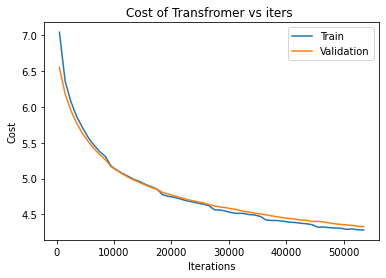

In [ ]:
# plot the cost
plt.plot(range(500,54500,1000),train_losses2)
plt.plot(range(500,54500,1000),validation_losses2)
plt.title("Cost of Transfromer vs iters ")
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.legend(labels = ["Train","Validation"])
plt.show()

Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/Transformer2.pth'
torch.save(model2.state_dict(), PATH)

In [ ]:
print(train_losses2)

[7.044583921909332, 6.3595043592453, 6.07445554971695, 5.8681496868133545, 5.715434666633606, 5.575719193935394, 5.4684157176017765, 5.378194270133972, 5.309905904769898, 5.174778644561767, 5.119003778934479, 5.070746387004852, 5.030598823547363, 4.988202484130859, 4.95817217206955, 4.9176596202850344, 4.887787534236908, 4.851358037948608, 4.773772130012512, 4.751644444465637, 4.73858655834198, 4.717497355937958, 4.692257964611054, 4.677892746448517, 4.65961946439743, 4.643309813976288, 4.623094560623169, 4.5636784477233885, 4.5618979017734524, 4.5451003775596615, 4.523619549274445, 4.51459657406807, 4.513636318206787, 4.497703789234161, 4.492364508628845, 4.4708758561611175, 4.420891220331192, 4.415192759990692, 4.413903271436691, 4.404896262645721, 4.390912525653839, 4.386796081542969, 4.376458330154419, 4.369233320474625, 4.356462274551392, 4.320657784461975, 4.32321314573288, 4.314762910604477, 4.310287416934967, 4.30654602098465, 4.291003308773041, 4.296266507863998, 4.28449872398

In [ ]:
print(validation_losses2)

[6.551886562984976, 6.183807052929306, 5.9499443915266506, 5.776914807149565, 5.632861478433333, 5.5206726271899145, 5.420868626940929, 5.337267530621156, 5.265813850666406, 5.165035012723351, 5.115109113752007, 5.063746893550613, 5.017508433757821, 4.9798573432516315, 4.943034940073137, 4.9101179707951905, 4.8776909127400145, 4.847597273569258, 4.806284184104143, 4.782784612906747, 4.758095909122214, 4.735826215378933, 4.712764090850573, 4.694577262069887, 4.676892681727334, 4.661713894007921, 4.637559575081762, 4.618094678018608, 4.603134909041233, 4.592768702520376, 4.578026972564996, 4.564280779978363, 4.543269932548316, 4.531779039028534, 4.517388723143676, 4.5061694053040835, 4.493172692762815, 4.478880666328523, 4.4649485103667725, 4.452687330495298, 4.444065264960964, 4.4349572400307675, 4.422237808519608, 4.416032886416081, 4.399968991426527, 4.402589618547513, 4.3935330673203525, 4.381490412657779, 4.368314714547521, 4.359261930378434, 4.353516557971303, 4.345493801279006, 4.

## Test

In [ ]:
torch.manual_seed(2045)

pad_idx = 0

# Parameters
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

# Training and validation Data Generators
test_set0 = AFEC_Dataset(en_test_dic_,fa_test_dic_0,partition2['test'],en_vocab_dic_, fa_vocab_dic_)
test_generator0 = torch.utils.data.DataLoader(test_set0, **params)
test_set1 = AFEC_Dataset(en_test_dic_,fa_test_dic_0,partition2['test'],en_vocab_dic_, fa_vocab_dic_)
test_generator1 = torch.utils.data.DataLoader(test_set1, **params)
test_set2 = AFEC_Dataset(en_test_dic_,fa_test_dic_0,partition2['test'],en_vocab_dic_, fa_vocab_dic_)
test_generator2 = torch.utils.data.DataLoader(test_set2, **params)
test_set3 = AFEC_Dataset(en_test_dic_,fa_test_dic_0,partition2['test'],en_vocab_dic_, fa_vocab_dic_)
test_generator3 = torch.utils.data.DataLoader(test_set3, **params)


# Hyperparameters
embed_dim = 256
num_heads = 8
dim_key = 64
dim_value = 64
dim_inner = 1024
num_layers = 3
src_vocab_size = len(en_vocab_dic_.get_str_2_idx())
trg_vocab_size = len(fa_vocab_dic_.get_str_2_idx())
learning_rate = 1e-4

kwargs = {'p_dropout': 0.1,
          'kdim': dim_key,
          'vdim':dim_value,
          }
# Model
PATH = '/content/drive/My Drive/Transformer2.pth'
model2 = Transformer(num_layers, embed_dim, dim_inner, num_heads, src_vocab_size,trg_vocab_size, device,**kwargs).to(device)
model2.load_state_dict(torch.load(PATH))

test_dataiter0 = iter(test_generator0)
test_dataiter1 = iter(test_generator1)
test_dataiter2 = iter(test_generator2)
test_dataiter3 = iter(test_generator3)

list_of_references = []
hypothesises = []
bleu_scores = []
nist_scores = []

# Loop over batches
for num_batch in tqdm(range(len(test_generator0))):
    # Test 
    with torch.set_grad_enabled(False):
        # Transfer to GPU
        batch_src0, batch_trg0 = test_dataiter0.next() 
        batch_src0, batch_trg0 = batch_src0.to(device), batch_trg0.to(device)
        batch_src1, batch_trg1 = test_dataiter1.next() 
        batch_src1, batch_trg1 = batch_src1.to(device), batch_trg1.to(device)
        batch_src2, batch_trg2 = test_dataiter2.next() 
        batch_src2, batch_trg2 = batch_src2.to(device), batch_trg2.to(device)
        batch_src3, batch_trg3 = test_dataiter3.next() 
        batch_src3, batch_trg3 = batch_src3.to(device), batch_trg3.to(device)

        # Model computations
        # forward + backward + optimize
        batch_outputs1 = model2(batch_src0, batch_trg0[: , :-1])
        batch_outputs = model2.translate_sentence(batch_src0, batch_trg0.shape[1] + 5, 1, 2)
        batch_outputs = torch.Tensor(batch_outputs)

        references = [fa_vocab_dic_.IndexDecoding(batch_trg0[0,:]),fa_vocab_dic_.IndexDecoding(batch_trg1[0,:]),
                      fa_vocab_dic_.IndexDecoding(batch_trg2[0,:]),fa_vocab_dic_.IndexDecoding(batch_trg3[0,:])]
        list_of_references.append(references)
        
        hypothesises.append(fa_vocab_dic_.IndexDecoding(batch_outputs))
        bleu_scores.append(sentence_bleu(references,fa_vocab_dic_.IndexDecoding(batch_outputs)))
        nist_scores.append(sentence_nist(references,fa_vocab_dic_.IndexDecoding(batch_outputs)))
        
        # print(batch_src0.shape, batch_trg0.shape, len(batch_outputs))
        # print(en_vocab_dic_.IndexDecoding(batch_src0[0,:])[1:-1])
        # print(fa_vocab_dic_.IndexDecoding(batch_trg0[0,:])[1:-1])
        # print(fa_vocab_dic_.IndexDecoding(batch_outputs)[1:-1])
        # if num_batch == 5:
        #   break

bleu_score = corpus_bleu(list_of_references, hypothesises) 
nist_score = corpus_nist(list_of_references, hypothesises, n = 5)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print(bleu_score,nist_score)

0.06977961030647861 0.0014485707827332276


In [ ]:
print(fa_vocab_dic_.IndexDecoding(torch.max(batch_outputs1, dim = 2)[1][0,:]))

In [ ]:
torch.manual_seed(2045)

pad_idx = 0

# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

# Training and validation Data Generators
test_set2 = AFEC_Dataset(en_test_dic_,fa_test_dic_0,partition2['test'],en_vocab_dic_, fa_vocab_dic_)
test_generator2 = torch.utils.data.DataLoader(test_set2, **params)

# Hyperparameters
embed_dim = 256
num_heads = 8
dim_key = 64
dim_value = 64
dim_inner = 1024
num_layers = 3
src_vocab_size = len(en_vocab_dic_.get_str_2_idx())
trg_vocab_size = len(fa_vocab_dic_.get_str_2_idx())
learning_rate = 1e-4
num_iterations = 10

kwargs = {'p_dropout': 0.1,
          'kdim': dim_key,
          'vdim':dim_value,
          }
# Model
# PATH = '/content/drive/My Drive/Transformer2.pth'
# model2 = Transformer(num_layers, embed_dim, dim_inner, num_heads, src_vocab_size,trg_vocab_size, device,**kwargs).to(device)
# model2.load_state_dict(torch.load(PATH))

test_dataiter2 = iter(test_generator2)

# Loop over epochs
for itr in tqdm(range(num_iterations)):
    
    # Test
    batch_src, batch_trg = test_dataiter2.next() 
    
    with torch.set_grad_enabled(False):


        # Model computations
        # forward + backward + optimize
        
        batch_outputs = model2.translate_sentence(batch_src, batch_trg.shape[1] + 5, 1, 2)
        batch_outputs = torch.Tensor(batch_outputs)

        print("Sentence {}:".format(itr + 1))
        print(" ".join(en_vocab_dic_.IndexDecoding(batch_src[0,:])).replace("<sos>", "").replace("<eos>", "."))
        print(" ".join(fa_vocab_dic_.IndexDecoding(batch_trg[0,:])).replace("<sos>", "").replace("<eos>", "").replace("<unk>","ن.ش"))
        print(" ".join(fa_vocab_dic_.IndexDecoding(batch_outputs)).replace("<sos>", "").replace("<eos>", "").replace("<unk>","ن.ش"))
        print("-"*50)


Sentence 1:
 once again shall we stay at the hotel grun￭ sch￭ nab￭ el .
 یکبار دیگر آیا قرار است در هتل گران￭ ش￭ ابل بمانیم 
 زمانی که ما در هتل هتل های هتل را در هتل ببینیم 
--------------------------------------------------
Sentence 2:
 fine let us go for a little walk in hamburg .
 خوب است اجازه دهید برای یک کوتاه در هامبورگ برویم 
 خوب است اجازه دهید برای ما در یک مکان کوچک 
--------------------------------------------------
Sentence 3:
 yes i have already booked the hotel .
 بله من در حال حاضر هتل را رزرو 
 بله من از هتل رزرو کردم 
--------------------------------------------------
Sentence 4:
 in the evening we should watch the newest movie with arnold schwarzenegger .
 عصر باید جدیدترین فیلم آرنولد شوا￭ ن.ش را تماشا کنیم 
 ما باید با فیلم فیلم فیلم ساز در عصر را با یک فیلم در سال به نمایش
--------------------------------------------------
Sentence 5:
 where should we meet .
 کجا باید ملاقات کنیم 
 ما باید به این ترتیب دهیم که به توافق رسید 
--------------------------------------

# Part 3:

## Preprocessing

### Load the dataset to colab directory 

For the sake of speed, copy the dataset files to the root directory of notebook and unziped them. 

In [ ]:
!cp /content/drive/My\ Drive/AFEC-merged-all.zip /content/AFEC-merged-all.zip

In [ ]:
!cp /content/drive/My\ Drive/Test.zip /content/Test.zip

In [ ]:
!unzip /content/AFEC-merged-all.zip

Archive:  /content/AFEC-merged-all.zip
  inflating: AFEC-merged.en          
  inflating: AFEC-merged.fa          


In [ ]:
os.rename('/content/AFEC-merged.en',"/content/AFEC-merged_en.txt")
os.rename('/content/AFEC-merged.fa',"/content/AFEC-merged_fa.txt")

In [ ]:
!unzip /content/Test.zip

Archive:  /content/Test.zip
   creating: Test/
  inflating: Test/test.en            
  inflating: Test/test.fa0           
  inflating: Test/test.fa1           
  inflating: Test/test.fa2           
  inflating: Test/test.fa3           


In [ ]:
os.rename('/content/Test/test.en',"/content/test_en.txt")
os.rename('/content/Test/test.fa0',"/content/test_fa0.txt")
os.rename('/content/Test/test.fa1',"/content/test_fa1.txt")
os.rename('/content/Test/test.fa2',"/content/test_fa2.txt")
os.rename('/content/Test/test.fa3',"/content/test_fa3.txt")

### Vocabulary 

In [ ]:
class Vocabulary_and_Dictionary():

    def __init__(self, freq_threshold = 2):
        self.freq_threshold = freq_threshold
        
        self.frequencies = {}
        self.idx_2_str = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.str_2_idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}

    def __len__(self):
        return len(self.idx_2_str)

    @staticmethod
    def preprocess(text):
        # prepare translation table for removing punctuation
        table = str.maketrans('', '', string.punctuation)

        # tokenize on white space
        text = text.split()
        # convert to lower case
        text = [word.lower() for word in text]
        # remove punctuation from each token
        text = [word.translate(table) for word in text]

        # remove tokens with numbers in them
        text = [word for word in text if word.isalpha()]
        
        return text

    def build_vocabulary_and_dictionary(self, text_file_root):

        self.dic = {}
        
        idx = 4
        lines = [line.strip() for line in open(text_file_root)]
        
        for i in range(len(lines)):

            words =  self.preprocess(lines[i])
            for word in words:
                if word not in self.frequencies:
                    self.frequencies[word] = 1

                else:
                    self.frequencies[word] += 1

                if self.frequencies[word] == self.freq_threshold:
                    self.str_2_idx[word] = idx
                    self.idx_2_str[idx] = word
                    idx += 1

            self.dic[i] = [" ".join(words)] 

    def IndexEncoding(self, text):
        tokenized_text = self.preprocess(text)
        index_encoded_text = [self.str_2_idx[token] if token in self.str_2_idx else self.str_2_idx["<unk>"]
                                for token in tokenized_text]
        
        return index_encoded_text

    def IndexDecoding(self, sen_tensor):
        tokenized_vec = list(sen_tensor.cpu().numpy())
        decoded_vec = [self.idx_2_str[token] for token in tokenized_vec]
        return decoded_vec

    def get_str_2_idx(self):
        return self.str_2_idx

    def get_dic(self):
        return self.dic

In [ ]:
en_vocab_dic = Vocabulary_and_Dictionary(freq_threshold = 10)

train_text_root = "/content/AFEC-merged_en.txt"
en_vocab_dic.build_vocabulary_and_dictionary(train_text_root)

en_train_dic = en_vocab_dic.get_dic() 

print(len(en_vocab_dic.get_str_2_idx()))

30032


In [ ]:
en_train_dic[0],len(en_train_dic)

(['north waziristan operation kills more militants'], 684417)

In [ ]:
fa_vocab_dic = Vocabulary_and_Dictionary(freq_threshold = 10)

train_text_root1 = "/content/AFEC-merged_fa.txt"
fa_vocab_dic.build_vocabulary_and_dictionary(train_text_root1)

fa_train_dic = fa_vocab_dic.get_dic() 

print(len(fa_vocab_dic.get_str_2_idx()))

In [ ]:
fa_train_dic[0],len(fa_train_dic)

In [ ]:
en_vocab_dic2 = Vocabulary_and_Dictionary(freq_threshold = 2)

test_text_root = "/content/test_en.txt"
en_vocab_dic2.build_vocabulary_and_dictionary(test_text_root)

en_test_dic = en_vocab_dic2.get_dic() 

print(len(en_vocab_dic2.get_str_2_idx()))

In [ ]:
fa_vocab_dic2 = Vocabulary_and_Dictionary(freq_threshold = 2)

test_text_root0 = "/content/test_fa0.txt"
fa_vocab_dic2.build_vocabulary_and_dictionary(test_text_root0)

fa_test_dic0 = fa_vocab_dic2.get_dic() 

test_text_root1 = "/content/test_fa1.txt"
fa_vocab_dic2.build_vocabulary_and_dictionary(test_text_root1)

fa_test_dic1 = fa_vocab_dic2.get_dic() 

test_text_root2 = "/content/test_fa2.txt"
fa_vocab_dic2.build_vocabulary_and_dictionary(test_text_root2)

fa_test_dic2 = fa_vocab_dic2.get_dic() 

test_text_root3 = "/content/test_fa3.txt"
fa_vocab_dic2.build_vocabulary_and_dictionary(test_text_root3)

fa_test_dic3 = fa_vocab_dic2.get_dic() 

print(len(fa_vocab_dic2.get_str_2_idx()))

In [ ]:
en_test_dic

In [ ]:
fa_vocab_dic2.get_str_2_idx()

### AFEC Dataset

In [ ]:
class AFEC_Dataset(torch.utils.data.Dataset):
    """
    Characterize AFEC Dataset for PyTorch. To be compatible with 
    DataLoader and other PyTorch syntaxes.
    """
    def __init__(self, src_dic, trg_dic, indices, src_vocab, trg_vocab):
        
        self.src_dic = src_dic
        self.trg_dic = trg_dic

        # Get img names, caption columns
        self.src_sentences = [self.src_dic[i] for i in indices]
        self.trg_sentences = [self.trg_dic[i] for i in indices]

        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab 
            
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.src_sentences)

    def __getitem__(self, index):
        """ 
        Generates one sample of data with label
        
        Arguments
        ------------
        index : integer, in range of len(self.list_IDs)
                index of sample in list of IDs,
        
        Returns
        ------------
        X : torch tensor,
            input data

        Y : torch tensor,
            correspond label of input data
        """
        # Select sample
        src_sentence = [ self.src_vocab.str_2_idx["<sos>"] ]
        src_sentence += self.src_vocab.IndexEncoding(self.src_sentences[index][0])
        src_sentence.append(self.src_vocab.str_2_idx["<eos>"])

        trg_sentence = [ self.trg_vocab.str_2_idx["<sos>"] ]
        trg_sentence += self.trg_vocab.IndexEncoding(self.trg_sentences[index][0])
        trg_sentence.append(self.trg_vocab.str_2_idx["<eos>"])
       
        tensor_src_sentence = torch.tensor(src_sentence)
        tensor_trg_sentence = torch.tensor(trg_sentence)

        return tensor_src_sentence , tensor_trg_sentence

### Split Dataset and Activate CUDA

In [ ]:
#train/val/test split 
random.seed(2045)

indices = list(range(len(en_train_dic)))
num_samples = len(en_train_dic)
random.shuffle(indices)

train_indices = indices[0 : int(0.9 * num_samples)]
validation_indices = indices[int(0.9 * num_samples) : ]
test_indices = list(range(len(en_test_dic)))

partition = {'train' : train_indices , 'validation' : validation_indices,
             'test' : test_indices }

In [ ]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [ ]:
device

In [ ]:
len(partition['test'])

### Padding

In [ ]:
class BatchPadCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):

        src_sentences = [item[0] for item in batch]
        src_sentences = pad_sequence(src_sentences, batch_first= True, padding_value=self.pad_idx)

        trg_sentences = [item[1] for item in batch]
        trg_sentences = pad_sequence(trg_sentences, batch_first= True, padding_value=self.pad_idx) 
        
        return src_sentences, trg_sentences 

## Transformer Network2 

In [ ]:
class PositionalEncoding(nn.Module):
    
    def __init__(self,embed_dim, p_dropout, maximum_position_encoding):
        super(PositionalEncoding, self).__init__()
        
        self.max_pos = maximum_position_encoding
        self.dropout = nn.Dropout(p_dropout)
        pos_enc = torch.zeros(self.max_pos, embed_dim)
        positions = torch.arange(0, self.max_pos, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pos_enc[:, 0::2] = torch.sin(positions * div_term)
        pos_enc[:, 1::2] = torch.cos(positions * div_term)
        pos_enc = pos_enc.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pos_enc', pos_enc)

    def forward(self, x):
        x = x + self.pos_enc[:x.size(0), :]
        x = self.dropout(x)
        
        return x


In [ ]:
class _ScaledDotProductAttention(nn.Module):
    
    def __init__(self, embed_dim, device, p_dropout=0., kdim=None, vdim=None):
        super(_ScaledDotProductAttention, self).__init__()
        self.device = device
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim

        self.dropout = nn.Dropout(p_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, query: Tensor, key: Tensor, value: Tensor, mask: Optional[Tensor] = None) -> Tuple[Tensor, Tensor]:
          
        """
        Calculate the attention weights.
        q, k, v must have matching leading dimensions.
        k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
        The mask has different shapes depending on its type(padding or look ahead)
        but it must be broadcastable for addition.

        Args:
            query : query shape == (..., seq_len_q, depth)
            key : key shape == (..., seq_len_k, depth)
            value: value shape == (..., seq_len_v, depth_v)
            mask: Float tensor with shape broadcastable
                to (..., seq_len_q, seq_len_k). Defaults to None.

        Returns:
            output, attention_weights
        """
        qk = torch.matmul(query, torch.transpose(key,2,3))  # (..., seq_len_q, seq_len_k)
        
        # scale matmul_qk
        scaled_attention_logits = qk / math.sqrt(self.kdim)

        # add the mask to the scaled tensor.
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
        
        # softmax is normalized on the last axis (seq_len_k) so that the scores
        # add up to 1.
        attention_weights = self.softmax(scaled_attention_logits)  # (..., seq_len_q, seq_len_k)
        
        attention_weights = self.dropout(attention_weights)
        
        output = torch.matmul(attention_weights, value)  # (..., seq_len_q, depth_v)

        return output

In [ ]:
class _MultiHeadAttention2(nn.Module):
    
    def __init__(self, embed_dim, num_heads, device, p_dropout=0.,
                 kdim=None, vdim=None, epsilon = 1e-5):
        super(_MultiHeadAttention2, self).__init__()
        
        self.device = device 
        self.embed_dim = embed_dim                               
        self.num_heads = num_heads
        self.kdim = kdim * num_heads if kdim is not None else embed_dim
        self.vdim = vdim * num_heads if vdim is not None else embed_dim
        self.d_model = self.vdim 
        self.head_dim = self.d_model // num_heads
        assert self.head_dim * num_heads == self.d_model, "embed_dim must be divisible by num_heads"

        self.Wq = nn.Linear(embed_dim, self.kdim,device = device)
        self.Wk = nn.Linear(embed_dim, self.kdim,device = device)
        self.Wv = nn.Linear(embed_dim, self.vdim,device = device)

        self.self_attention = _ScaledDotProductAttention(self.head_dim, device,p_dropout, kdim, vdim)
        self.layernorm = nn.LayerNorm((embed_dim,), eps = epsilon, device = device)
        self.linear = nn.Linear(self.vdim, embed_dim,device = device)
        self.dropout = nn.Dropout(p_dropout)

    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = x.view((batch_size, -1, self.num_heads, self.head_dim))
        return torch.transpose(x,1,2)

    def forward(self, query: Tensor, key: Tensor, value: Tensor, mask: Optional[Tensor] = None) -> Tuple[Tensor, Tensor]:
        
        batch_size = query.shape[0]

        q = self.Wq(query)  # (batch_size, seq_len, d_model)
        k = self.Wk(key)    # (batch_size, seq_len, d_model)
        v = self.Wv(value)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention = self.self_attention(q, k, v, mask)

        scaled_attention = torch.transpose(scaled_attention, 1,2)  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = scaled_attention.reshape((batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.linear(concat_attention)  # (batch_size, seq_len_q, d_model)

        output = self.dropout(output)
        output = self.layernorm(output)
        return output

In [ ]:
class _PointwiseFeedicorward(nn.Module):
    
    def __init__(self, embed_dim, inner_dim,device, p_dropout=0.,epsilon = 1e-5):
        super(_PointwiseFeedicorward, self).__init__()

        self.linear1 = nn.Linear(embed_dim, inner_dim,device = device)
        self.linear2 = nn.Linear(inner_dim, embed_dim,device = device)
        self.layernorm = nn.LayerNorm((embed_dim,), eps = epsilon,device = device)
        self.dropout = nn.Dropout(p_dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = self.linear1(x)
        x1 = self.relu(x1)
        x1 = self.dropout(x1)
        x1 = self.linear2(x1)
        x1 = self.dropout(x1) 
        x1 = self.layernorm(x + x1)

        return x1

In [ ]:
class _EncoderLayer2(nn.Module):
    
    def __init__(self, embed_dim, inner_dim, num_heads, device, p_dropout = 0.,
                 kdim = None, vdim = None,epsilon = 1e-5):
        super(_EncoderLayer2, self).__init__()

        self.device = device
        self.mha = _MultiHeadAttention2(embed_dim, num_heads, device, p_dropout, kdim, vdim)
        self.ff =  _PointwiseFeedicorward(embed_dim, inner_dim, device, p_dropout,epsilon = 1e-5)

    def forward(self, x, mask = None):
        
        x = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        x = self.ff(x)         # (batch_size, input_seq_len, d_model)

        return x

In [ ]:
class _TransformerEncoder2(nn.Module):
    
    def __init__(self,num_layers, embed_dim,inner_dim, num_heads, device,
                 p_dropout = 0., kdim = None, vdim = None, epsilon = 1e-5):
        
        super(_TransformerEncoder2, self).__init__()

        self.num_layers = num_layers 
        self.device = device
        
        kwrgs = {'p_droput': p_dropout, 'kdim': kdim, 'vdim': vdim, 'epsilon': epsilon}
        self.enc_layers = [_EncoderLayer2(embed_dim, inner_dim, num_heads,device,**kwargs) for _ in range(num_layers)]

    def forward(self, x, mask):
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [ ]:
class Transformer2(nn.Module):

    def __init__(self, num_layers, embed_dim, ff_dim, num_heads, src_vocab_size,
                 trg_vocab_size, device, p_dropout = 0., kdim = None,
                 vdim = None, maximum_position_encoding = 5000, epsilon = 1e-5):
        
        super(Transformer2, self).__init__()

        self.device = device
        self.scale = embed_dim
        self.src_embedding = nn.Embedding(src_vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, p_dropout, maximum_position_encoding)
        kwrgs = {'p_droput': p_dropout, 'kdim': kdim, 'vdim': vdim, 'epsilon': epsilon}
        self.transformer_encoder = _TransformerEncoder2(num_layers, embed_dim, ff_dim,
                                                       num_heads,device = device, **kwargs)
        

        self.trg_embedding = nn.Embedding(trg_vocab_size, embed_dim)
        self.pos_decoder = PositionalEncoding(embed_dim, p_dropout, maximum_position_encoding)
        self.decoder_layer = TransformerDecoderLayer(embed_dim, num_heads, dim_feedforward = ff_dim,
                                                     dropout = p_dropout, layer_norm_eps = epsilon, 
                                                     batch_first = True, device = device)
        self.transformer_decoder = TransformerDecoder(self.decoder_layer, num_layers)


        self.trg_classifier = nn.Linear(embed_dim, trg_vocab_size)

    def make_padding_mask(self, seq, pad_idx):
        seq_mask = seq == pad_idx
        return seq_mask.to(self.device)
    
    def make_src_padding_mask(self, seq, pad_idx):
        seq_mask = seq == pad_idx
        return seq_mask.view(seq.shape[0],1,1,-1).to(self.device)

    def generate_square_subsequent_mask(self, sz: int) -> Tensor:
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask.to(self.device)

    def forward(self, src, trg):
        
        src_padding_mask = self.make_src_padding_mask(src, 0)
        mem_padding_mask = self.make_padding_mask(src, 0)
        src = self.src_embedding(src).to(self.device)
        src = self.pos_encoder(src).to(self.device)

        enc_output = self.transformer_encoder(src, src_padding_mask) # (batch_size, src_seq_len, d_model)


        trg_padding_mask = self.make_padding_mask(trg, 0)
        trg_mask = self.generate_square_subsequent_mask(trg.shape[1])
        kwargs = {'tgt_mask': trg_mask, 'tgt_key_padding_mask': trg_padding_mask, 'memory_key_padding_mask': mem_padding_mask}
        trg = self.trg_embedding(trg).to(self.device)
        trg = self.pos_decoder(trg).to(self.device)

        dec_output = self.transformer_decoder(trg, enc_output,**kwargs) # (batch_size, trg_seq_len, d_model)


        final_output = self.trg_classifier(dec_output) # (batch_size, trg_seq_len, trg_vocab_size)

        return final_output
    def encode(self, src, mask):
        src = self.src_embedding(src).to(self.device) * math.sqrt(self.scale)
        src = self.pos_encoder(src)

        enc_output = self.transformer_encoder(src, mask) # (batch_size, src_seq_len, d_model)
        return enc_output
    
    def decode(self, trg, src_enc, trg_mask, mem_padding_mask):
        kwargs = {'tgt_mask': trg_mask,'memory_key_padding_mask': mem_padding_mask}
        
        trg = self.trg_embedding(trg).to(self.device) * math.sqrt(self.scale)
        trg = self.pos_decoder(trg)
        # dec_output.shape == (batch_size, trg_seq_len, d_model)
        dec_output = self.transformer_decoder(trg, src_enc, **kwargs)
        final_output = self.trg_classifier(dec_output) # (batch_size, trg_seq_len, trg_vocab_size)

        return final_output

    def translate_sentence(self,src,max_len, sos_idx, eos_idx):
        src = src.to(self.device)
        src_padding_mask = self.make_src_padding_mask(src, 0)
        mem_padding_mask = self.make_padding_mask(src, 0)

        enc_src = self.encode(src, src_padding_mask)

        trg_indexes = [sos_idx]

        for i in range(max_len):

            trg = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
            trg_mask = self.generate_square_subsequent_mask(trg.shape[1])

            output = self.decode(trg, enc_src, trg_mask, mem_padding_mask)
            
            pred_token = output.argmax(2)[:,-1].item()
            
            trg_indexes.append(pred_token)

            if pred_token == eos_idx:
                break
        
        return trg_indexes

## Training 

In [ ]:
torch.manual_seed(2045)

pad_idx = 0

# Parameters
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

# Training and validation Data Generators
training_set = AFEC_Dataset(en_train_dic,fa_train_dic,partition['train'],en_vocab_dic, fa_vocab_dic)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set =  AFEC_Dataset(en_train_dic,fa_train_dic,partition['validation'],en_vocab_dic, fa_vocab_dic)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

# Hyperparameters
embed_dim = 256
num_heads = 8
dim_key = 64
dim_value = 64
dim_inner = 1024
num_layers = 3
src_vocab_size = len(en_vocab_dic.get_str_2_idx())
trg_vocab_size = len(fa_vocab_dic.get_str_2_idx())
learning_rate = 1e-4
num_iterations = 5000

kwargs = {'p_dropout': 0.1,
          'kdim': dim_key,
          'vdim':dim_value,
          }
# Model
# model3 = Transformer2(num_layers, embed_dim, dim_inner, num_heads, src_vocab_size,trg_vocab_size, device,**kwargs).to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)
optimizer = optim.Adam(model3.parameters(), lr = learning_rate, betas=(0.9, 0.98), eps=1e-9)

# train_losses3 = []
# validation_losses3 = []

torch.autograd.set_detect_anomaly(True)

train_dataiter = iter(training_generator)

trainloss, valloss, running_trainloss, running_valloss = 0.0, 0.0, 0.0, 0.0

# Loop over epochs
for itr in tqdm(range(num_iterations)):

    # Training        
    batch_train_src, batch_train_trg = train_dataiter.next()

    # Transfer to GPU
    batch_train_src, batch_train_trg = batch_train_src.to(device), batch_train_trg.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = model3(batch_train_src, batch_train_trg[: , :-1])
    
    loss = criterion(torch.transpose(batch_train_outputs,1,2), batch_train_trg[: , 1:])

    loss.backward()

    # Clip to avoid exploding gradient issues, makes sure grads are within a healthy range
    nn.utils.clip_grad_norm_(model3.parameters(), max_norm=1,error_if_nonfinite= False)

    optimizer.step()

    # print statistics
    trainloss += loss.item()
    
    # Validation
    if itr % 500 == 499:
        with torch.set_grad_enabled(False):
            val_cnt = 1
            for batch_src, batch_trg in tqdm(validation_generator):
                # Transfer to GPU
                batch_src, batch_trg = batch_src.to(device), batch_trg.to(device)
                
                # Model computations
                # forward + backward + optimize
                batch_outputs = model3(batch_src, batch_trg[: , :-1])
                
                val_loss = criterion(torch.transpose(batch_outputs,1,2), batch_trg[: , 1:])

                valloss += val_loss.item()
                val_cnt += 1

        print("Cost of Train data after %i iterations : %f" %(itr + 1, trainloss / 500))
        print("Cost of Validation data after %i iterations: %f" %(itr + 1, valloss / val_cnt))
        running_valloss = 0

        train_losses3.append(trainloss/500)
        trainloss = 0
        validation_losses3.append(valloss/val_cnt)
        valloss = 0 


Cost of Train data after 500 iterations : 4.897921
Cost of Validation data after 500 iterations: 4.944427



Cost of Train data after 1000 iterations : 4.890292
Cost of Validation data after 1000 iterations: 4.932391



Cost of Train data after 1500 iterations : 4.881585
Cost of Validation data after 1500 iterations: 4.919564



Cost of Train data after 2000 iterations : 4.875365
Cost of Validation data after 2000 iterations: 4.912429



Cost of Train data after 2500 iterations : 4.869326
Cost of Validation data after 2500 iterations: 4.902979



Cost of Train data after 3000 iterations : 4.855814
Cost of Validation data after 3000 iterations: 4.892675



Cost of Train data after 3500 iterations : 4.859946
Cost of Validation data after 3500 iterations: 4.885011



Cost of Train data after 4000 iterations : 4.847824
Cost of Validation data after 4000 iterations: 4.879061



Cost of Train data after 4500 iterations : 4.841477
Cost of Validation data after 4500 iterations: 4.871543


StopIteration: ignored

In [ ]:
train_dataiter = iter(training_generator)

trainloss, valloss, running_trainloss, running_valloss = 0.0, 0.0, 0.0, 0.0

# Loop over epochs
for itr in tqdm(range(num_iterations)):

    # Training        
    batch_train_src, batch_train_trg = train_dataiter.next()

    # Transfer to GPU
    batch_train_src, batch_train_trg = batch_train_src.to(device), batch_train_trg.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()
    
    # Model computations
    # forward + backward + optimize
    batch_train_outputs = model3(batch_train_src, batch_train_trg[: , :-1])
    
    loss = criterion(torch.transpose(batch_train_outputs,1,2), batch_train_trg[: , 1:])

    loss.backward()

    # Clip to avoid exploding gradient issues, makes sure grads are within a healthy range
    nn.utils.clip_grad_norm_(model3.parameters(), max_norm=1,error_if_nonfinite= False)

    optimizer.step()

    # print statistics
    trainloss += loss.item()
    
    # Validation
    if itr % 500 == 499:
        with torch.set_grad_enabled(False):
            val_cnt = 1
            for batch_src, batch_trg in tqdm(validation_generator):
                # Transfer to GPU
                batch_src, batch_trg = batch_src.to(device), batch_trg.to(device)
                
                # Model computations
                # forward + backward + optimize
                batch_outputs = model3(batch_src, batch_trg[: , :-1])
                
                val_loss = criterion(torch.transpose(batch_outputs,1,2), batch_trg[: , 1:])

                valloss += val_loss.item()
                val_cnt += 1

        print("Cost of Train data after %i iterations : %f" %(itr + 1, trainloss / 500))
        print("Cost of Validation data after %i iterations: %f" %(itr + 1, valloss / val_cnt))
        running_valloss = 0

        train_losses3.append(trainloss/500)
        trainloss = 0
        validation_losses3.append(valloss/val_cnt)
        valloss = 0 


Cost of Train data after 500 iterations : 4.879543
Cost of Validation data after 500 iterations: 4.925639



Cost of Train data after 1000 iterations : 4.876445
Cost of Validation data after 1000 iterations: 4.919487


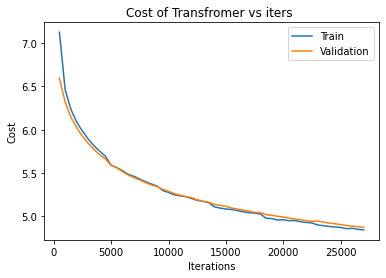

In [ ]:
# plot the cost
plt.plot(range(500,27500,500),train_losses3)
plt.plot(range(500,27500,500),validation_losses3)
plt.title("Cost of Transfromer vs iters ")
plt.ylabel('Cost')
plt.xlabel('Iterations')
plt.legend(labels = ["Train","Validation"])
plt.show()

Let’s quickly save our trained model:

In [ ]:
PATH = '/content/drive/My Drive/Transformer3.pth'
torch.save(model3.state_dict(), PATH)

In [ ]:
print(train_losses3)

[7.12672170829773, 6.46189419555664, 6.236063598632812, 6.0882855920791625, 5.984243896484375, 5.893051532745361, 5.8159049062728885, 5.752507901191711, 5.693956283569336, 5.589580288887024, 5.561838900566101, 5.5255132074356075, 5.484324089050293, 5.460690399169922, 5.428388655662537, 5.398866388320923, 5.372425700187683, 5.348479837417602, 5.296341809272766, 5.274308337211609, 5.247021976470947, 5.2354551630020145, 5.225406174659729, 5.205230780601502, 5.182973200798035, 5.172115510940552, 5.155914067268371, 5.107554347991943, 5.0938058843612675, 5.083502143859863, 5.07703448677063, 5.06543288230896, 5.051340876579284, 5.039793697357178, 5.0355708208084105, 5.025488792419433, 4.975865616798401, 4.972390535354614, 4.956974133491516, 4.958637884140015, 4.9479644947052, 4.950071088790893, 4.935765158653259, 4.92771598148346, 4.921769055366516, 4.897920921325683, 4.89029215335846, 4.881584662437439, 4.875364864349366, 4.869326411247253, 4.855814215660096, 4.85994566822052, 4.847824262619

In [ ]:
print(validation_losses3)

[6.595450358604317, 6.319155782905977, 6.145209693196994, 6.025102307547384, 5.924179872470115, 5.843560733901921, 5.772663861068327, 5.712082989180266, 5.661628710689829, 5.588227617206858, 5.558168792902534, 5.513683267493747, 5.475574759405051, 5.445043104798047, 5.417688414232055, 5.388465998777702, 5.361304210193121, 5.341884521406088, 5.309326466339738, 5.288369896696575, 5.261506803889773, 5.244026640457894, 5.2267997478371235, 5.214895077605746, 5.189556590656736, 5.173087774817623, 5.160829005846336, 5.13502259930568, 5.124514014863256, 5.114749619320257, 5.09394990419274, 5.083499680704145, 5.069631059667957, 5.059901949185044, 5.044191746569392, 5.040572052571311, 5.018282630550328, 5.01050619936701, 4.998459825764841, 4.990631580352783, 4.977491056741173, 4.967902800040458, 4.958835430109679, 4.948803663253784, 4.940747006615596, 4.944426836362526, 4.932391153342688, 4.919563938432665, 4.912429244660619, 4.902979107045415, 4.892674973651545, 4.88501096572449, 4.879061398221

In [ ]:
train_losses3 = [7.12672170829773, 6.46189419555664, 6.236063598632812, 6.0882855920791625, 5.984243896484375, 5.893051532745361, 5.8159049062728885, 5.752507901191711, 5.693956283569336, 5.589580288887024, 5.561838900566101, 5.5255132074356075, 5.484324089050293, 5.460690399169922, 5.428388655662537, 5.398866388320923, 5.372425700187683, 5.348479837417602, 5.296341809272766, 5.274308337211609, 5.247021976470947, 5.2354551630020145, 5.225406174659729, 5.205230780601502, 5.182973200798035, 5.172115510940552, 5.155914067268371, 5.107554347991943, 5.0938058843612675, 5.083502143859863, 5.07703448677063, 5.06543288230896, 5.051340876579284, 5.039793697357178, 5.0355708208084105, 5.025488792419433, 4.975865616798401, 4.972390535354614, 4.956974133491516, 4.958637884140015, 4.9479644947052, 4.950071088790893, 4.935765158653259, 4.92771598148346, 4.921769055366516]

In [ ]:
validation_losses3 = [6.595450358604317, 6.319155782905977, 6.145209693196994, 6.025102307547384, 5.924179872470115, 5.843560733901921, 5.772663861068327, 5.712082989180266, 5.661628710689829, 5.588227617206858, 5.558168792902534, 5.513683267493747, 5.475574759405051, 5.445043104798047, 5.417688414232055, 5.388465998777702, 5.361304210193121, 5.341884521406088, 5.309326466339738, 5.288369896696575, 5.261506803889773, 5.244026640457894, 5.2267997478371235, 5.214895077605746, 5.189556590656736, 5.173087774817623, 5.160829005846336, 5.13502259930568, 5.124514014863256, 5.114749619320257, 5.09394990419274, 5.083499680704145, 5.069631059667957, 5.059901949185044, 5.044191746569392, 5.040572052571311, 5.018282630550328, 5.01050619936701, 4.998459825764841, 4.990631580352783, 4.977491056741173, 4.967902800040458, 4.958835430109679, 4.948803663253784, 4.940747006615596]

## Test 

In [ ]:
torch.manual_seed(2045)

pad_idx = 0

# Parameters
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

# Training and validation Data Generators
test_set0 = AFEC_Dataset(en_test_dic,fa_test_dic0,partition['test'],en_vocab_dic, fa_vocab_dic)
test_generator0 = torch.utils.data.DataLoader(test_set0, **params)
test_set1 = AFEC_Dataset(en_test_dic,fa_test_dic0,partition['test'],en_vocab_dic, fa_vocab_dic)
test_generator1 = torch.utils.data.DataLoader(test_set1, **params)
test_set2 = AFEC_Dataset(en_test_dic,fa_test_dic0,partition['test'],en_vocab_dic, fa_vocab_dic)
test_generator2 = torch.utils.data.DataLoader(test_set2, **params)
test_set3 = AFEC_Dataset(en_test_dic,fa_test_dic0,partition['test'],en_vocab_dic, fa_vocab_dic)
test_generator3 = torch.utils.data.DataLoader(test_set3, **params)


# Hyperparameters
embed_dim = 256
num_heads = 8
dim_key = 64
dim_value = 64
dim_inner = 1024
num_layers = 3
src_vocab_size = len(en_vocab_dic.get_str_2_idx())
trg_vocab_size = len(fa_vocab_dic.get_str_2_idx())
learning_rate = 1e-4

kwargs = {'p_dropout': 0.1,
          'kdim': dim_key,
          'vdim':dim_value,
          }
# Model
# PATH = '/content/drive/My Drive/Transformer3.pth'
# model3 = Transformer2(num_layers, embed_dim, dim_inner, num_heads, src_vocab_size,trg_vocab_size, device,**kwargs).to(device)
# model3.load_state_dict(torch.load(PATH))

test_dataiter0 = iter(test_generator0)
test_dataiter1 = iter(test_generator1)
test_dataiter2 = iter(test_generator2)
test_dataiter3 = iter(test_generator3)

list_of_references = []
hypothesises = []
bleu_scores = []
nist_scores = []

# Loop over batches
for num_batch in tqdm(range(len(test_generator0))):
    # Test 
    with torch.set_grad_enabled(False):
        # Transfer to GPU
        batch_src0, batch_trg0 = test_dataiter0.next() 
        batch_src0, batch_trg0 = batch_src0.to(device), batch_trg0.to(device)
        batch_src1, batch_trg1 = test_dataiter1.next() 
        batch_src1, batch_trg1 = batch_src1.to(device), batch_trg1.to(device)
        batch_src2, batch_trg2 = test_dataiter2.next() 
        batch_src2, batch_trg2 = batch_src2.to(device), batch_trg2.to(device)
        batch_src3, batch_trg3 = test_dataiter3.next() 
        batch_src3, batch_trg3 = batch_src3.to(device), batch_trg3.to(device)

        # Model computations
        # forward + backward + optimize
        batch_outputs1 = model3(batch_src0, batch_trg0[: , :-1])
        batch_outputs = model3.translate_sentence(batch_src0, batch_trg0.shape[1] + 5, 1, 2)
        batch_outputs = torch.Tensor(batch_outputs)

        references = [fa_vocab_dic.IndexDecoding(batch_trg0[0,:]),fa_vocab_dic.IndexDecoding(batch_trg1[0,:]),
                      fa_vocab_dic.IndexDecoding(batch_trg2[0,:]),fa_vocab_dic.IndexDecoding(batch_trg3[0,:])]
        list_of_references.append(references)
        
        hypothesises.append(fa_vocab_dic.IndexDecoding(batch_outputs))
        bleu_scores.append(sentence_bleu(references,fa_vocab_dic.IndexDecoding(batch_outputs)))
        nist_scores.append(sentence_nist(references,fa_vocab_dic.IndexDecoding(batch_outputs)))
        
        # print(batch_src0.shape, batch_trg0.shape, len(batch_outputs))
        # print(en_vocab_dic.IndexDecoding(batch_src0[0,:])[1:-1])
        # print(fa_vocab_dic.IndexDecoding(batch_trg0[0,:])[1:-1])
        # print(fa_vocab_dic.IndexDecoding(batch_outputs)[1:-1])
        # if num_batch == 5:
        #   break

bleu_score = corpus_bleu(list_of_references, hypothesises) 
nist_score = corpus_nist(list_of_references, hypothesises, n = 5)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print(bleu_score,nist_score)

0.044645439571308496 0.001183667412512276


In [ ]:
print(np.mean(bleu_scores),np.mean(nist_scores))

0.5397333763223582 0.013743155283581648


In [ ]:
print(fa_vocab_dic.IndexDecoding(torch.max(batch_outputs1, dim = 2)[1][0,:]))

['بله', 'ما', 'ساعت', 'عصر', 'امروز', 'که', 'ما', 'چیز', 'درباره', 'کنیم', 'ما']


In [ ]:
torch.manual_seed(2045)

pad_idx = 0

# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers':2,
          'collate_fn' : BatchPadCollate(pad_idx=pad_idx)
          }

# Training and validation Data Generators
test_set = AFEC_Dataset(en_test_dic,fa_test_dic0,partition['test'],en_vocab_dic, fa_vocab_dic)
test_generator = torch.utils.data.DataLoader(test_set, **params)

# Hyperparameters
embed_dim = 256
num_heads = 8
dim_key = 64
dim_value = 64
dim_inner = 1024
num_layers = 3
src_vocab_size = len(en_vocab_dic.get_str_2_idx())
trg_vocab_size = len(fa_vocab_dic.get_str_2_idx())
learning_rate = 1e-4
num_iterations = 10

kwargs = {'p_dropout': 0.1,
          'kdim': dim_key,
          'vdim':dim_value,
          }
# Model
# PATH = '/content/drive/My Drive/Transformer1.pth'
# model3 = Transformer2(num_layers, embed_dim, dim_inner, num_heads, src_vocab_size,trg_vocab_size, device,**kwargs).to(device)
# model3.load_state_dict(torch.load(PATH))

test_dataiter = iter(test_generator)

# Loop over epochs
for itr in tqdm(range(num_iterations)):
    
    # Test
    batch_src, batch_trg = test_dataiter.next() 
    
    with torch.set_grad_enabled(False):


        # Model computations
        # forward + backward + optimize
        
        batch_outputs = model3.translate_sentence(batch_src, batch_trg.shape[1] + 5, 1, 2)
        batch_outputs = torch.Tensor(batch_outputs)

        print("Sentence {}:".format(itr + 1))
        print(" ".join(en_vocab_dic.IndexDecoding(batch_src[0,:])).replace("<sos>", "").replace("<eos>", "."))
        print(" ".join(fa_vocab_dic.IndexDecoding(batch_trg[0,:])).replace("<sos>", "").replace("<eos>", "").replace("<unk>","ن.ش"))
        print(" ".join(fa_vocab_dic.IndexDecoding(batch_outputs)).replace("<sos>", "").replace("<eos>", "").replace("<unk>","ن.ش"))
        print("-"*50)

Sentence 1:
 once again shall we stay at the hotel <unk> .
 یکبار دیگر آیا قرار است در هتل ن.ش بمانیم 
 ما را در ساعت ما آه آه آه آه آه ما میتوانیم ما میتوانیم میتوانیم ساعت
--------------------------------------------------
Sentence 2:
 fine let us go for a little walk in hamburg .
 خوب است اجازه دهید برای یک کوتاه در هامبورگ برویم 
 شما شما ن.ش شما شما شما شما شما را شما شما شما شما شما را 
--------------------------------------------------
Sentence 3:
 yes i have already booked the hotel .
 بله من در حال حاضر هتل را رزرو 
 من من من را من و بیست من بیست و بیست و من و بیست
--------------------------------------------------
Sentence 4:
 in the evening we should watch the newest movie with arnold schwarzenegger .
 عصر باید جدیدترین فیلم آرنولد ن.ش را تماشا کنیم 
 و ما را ن.ش 
--------------------------------------------------
Sentence 5:
 where should we meet .
 کجا باید ملاقات کنیم 
 ما ما میتوانیم ما را خواهیم ما خواهیم کنیم ما ما
--------------------------------------------------
Sen